# Example for processing proximity data collected by a hub

The badges scans for other badges and iBeacons every time interval. The time interval, called time_slice in this example, is set by the hub and usually configured for 60 seconds.

Each scan appears as a JSON object, containing the member key of the scanning badge, it's MAC address, timestamp of the scan, voltage at the time of the scan, and a list of other bluetooth devices picked up by the scan. 

In order to preserve storage space, we do not save the MAC addresses of the the badges found in th scan. Instead, we store only the badge ID - a 16-bit unique identifier that each badge broadcasts. This ID can be set manually, but at the time of writing this example, the ID is created using CRC16 based on the MAC address. 

Since members may change their badges during the experiment, it's important to perform the analysis using member keys.

Code credits - Xavier Lambein

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

import os, sys
import logging
import json
import gzip
# import cv2
import glob

from collections import Counter

# Import the data analysis tools
import openbadge_analysis as ob
import openbadge_analysis.preprocessing
import openbadge_analysis.core

SELECTED_BEACON = 12
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
ob.__version__

'0.4.4'

# Settings
The time_zone variable will be used when converting the timestamp form UTC time to your local time.

In [3]:
time_zone = 'US/Eastern'
log_version = '2.0'
time_bins_size = '1min'

proximity_data_filenames = []

for i in range(1, 18):
    if i < 10:
        filename = 'CTSIserver{:02d}_proximity_2019-06-01.txt'.format(i)
    else:
        filename = 'CTSIserver{}_proximity_2019-06-01.txt'.format(i)
        
    proximity_data_filenames.append(filename)
    
members_metadata_filename = "Member-2019-05-28.csv"
beacons_metadata_filename = "location table.xlsx"
# data_dir = "/Users/Robert/Desktop/DSC383W/Capstone-URMC/proximity_2019-06-01/"
data_dir = "/Users/songziyu/Desktop/Capstone-URMC/proximity_2019-06-01/"

# Pre-processing

First, we load two lists that will help us with some of the analysis: list of membmers and list of location beacons

In [4]:
members_metadata = pd.read_csv(data_dir+members_metadata_filename)
members_metadata.dropna()
beacons_metadata = pd.read_excel(data_dir+beacons_metadata_filename, sheet_name='Sheet1')

# Calculating the id of the beacon based on it's MAC address
# beacons_metadata['id'] = beacons_metadata.apply(
#     lambda row: ob.core.mac_address_to_id(row['badge_address']),
#     axis=1
# )

In [5]:
members_metadata

,member,date_created,date_updated,id,email,name,badge,observed_id,active,comments,last_audio_ts,last_audio_ts_fract,last_proximity_ts,last_contacted_ts,last_voltage,last_seen_ts,last_unsync_ts,project,region
0,W7SXW19MPM,2019/5/28 12:56,2019/5/28 12:56,115,NaN,Badge412,F7:CA:E5:74:BD:06,0,1,NaN,1559048174,0,1559048174,0,0.00,0,0,1,Team1
1,EJCJZNKPMG,2019/5/28 12:56,2019/5/28 12:56,114,NaN,Badge411,E3:5F:B7:80:8C:1E,0,1,NaN,1559048174,0,1559048174,0,0.00,0,0,1,Team1
2,VVVQLVOOD1,2019/5/28 12:56,2019/5/28 12:56,113,NaN,Badge410,E4:1D:B0:47:33:71,0,1,NaN,1559048174,0,1559048174,0,0.00,0,0,1,Team1
3,5JXIHCGASC,2019/5/28 12:56,2019/5/28 12:56,112,NaN,Badge409,E1:8B:6E:0E:2C:7A,0,1,NaN,1559048174,0,1559048174,0,0.00,0,0,1,Team1
4,413V07OIU6,2019/5/28 12:56,2019/5/28 12:56,111,NaN,Badge408,C5:0E:A8:0B:48:16,0,1,NaN,1559048174,0,1559048174,0,0.00,0,0,1,Team1
5,CXF4MJ608A,2019/5/28 12:56,2019/5/28 12:56,110,NaN,Badge407,C1:5F:E7:20:36:70,0,1,NaN,1559048174,0,1559048174,0,0.00,0,0,1,Team1
6,DHSPP0NHW7,2019/5/28 12:56,2019/5/28 12:56,109,NaN,Badge406,CB:C9:45:50:D3:5E,0,1,NaN,1559048174,0,1559048174,0,0.00,0,0,1,Team1
7,NI0TDDLD7F,2019/5/28 12:56,2019/5/28 12:56,108,NaN,Badge405,CE:D9:95:42:3A:DC,0,1,NaN,1559048174,0,1559048174,0,0.00,0,0,1,Team1
8,2LF6XKYHWV,2019/5/28 12:56,2019/5/28 12:56,107,NaN,Badge404,EA:B7:52:4E:27:2F,0,1,NaN,1559048174,0,1559048174,0,0.00,0,0,1,Team1
9,HBVNN0KU8I,2019/5/28 12:56,2019/5/28 12:56,106,NaN,Badge403,F5:DB:FF:8D:0C:97,0,1,NaN,1559048174,0,1559048174,0,0.00,0,0,1,Team1


## beacons_metadata

We create a translation table between the badge ID and member key. This is done based on the data itself, since it should contain data from all the badges that take part in the study. 

Note that we create a <id,member key> pair for ever time bin. While this is not necessary at this point, it allows this mapping to change (for example, if a badge is re-assigned to a different member).

In [6]:
idmaps = []

for proximity_data_filename in proximity_data_filenames:
    with open(os.path.join(data_dir, proximity_data_filename), 'r') as f:
        idmaps.append(ob.preprocessing.id_to_member_mapping(f, time_bins_size, tz=time_zone))
        
tmp_idmaps = idmaps[0]
for i in range(1, len(idmaps)):
    tmp_idmaps = pd.concat([tmp_idmaps, idmaps[i]])

In [7]:
idmap_beacon = tmp_idmaps
startmin = 25
for i in beacons_metadata[['key', 'id']].iterrows():
    beacon_id = i[1][1]
    beacon_key = i[1][0]
    
    tmp = pd.DataFrame(['2019-06-01 14:{}:00-04:00'.format(startmin), beacon_id, beacon_key]).transpose()
    startmin += 1
    tmp.columns = ['datetime', 'id', 'member']
    idmap_beacon = pd.concat([idmap_beacon, tmp])

Using this translation table and the proximity data, we can create a list of "pings" - every time two badges were in close proximity

In [8]:
m2badges = []

for proximity_data_filename in proximity_data_filenames:
    with open(os.path.join(data_dir, proximity_data_filename), 'r') as f:
        m2badges.append(ob.preprocessing.member_to_badge_proximity(f, time_bins_size, tz=time_zone))
        
tmp_m2badges = m2badges[0]

for i in range(1, len(m2badges)):
    tmp_m2badges = pd.concat([tmp_m2badges, m2badges[i]])

Since a badge can either be a badge worn by a participant, or a location beacon, we split the dataset into member-to-member (for network graphs) and member-to-beacon (for localization)

In [9]:
# Member to member
m2ms = []
for (m2badge, idmap) in zip(m2badges, idmaps):
    m2ms.append(ob.preprocessing.member_to_member_proximity(m2badge, idmap))
    
tmp_m2ms = m2ms[0]
for i in range(1, len(m2ms)):
    tmp_m2ms = pd.concat([tmp_m2ms, m2ms[i]])

In [10]:
# Member to location beacon
m2bs = []
for m2badge in m2badges:
    m2bs.append(ob.preprocessing.member_to_beacon_proximity(m2badge, beacons_metadata.set_index('id')['beacon']))
    
tmp_m2bs = m2bs[0]
for i in range(1, len(m2bs)):
    tmp_m2bs = pd.concat([tmp_m2bs, m2bs[i]])

 Member 5 closest beacons

In [11]:
m5cb = tmp_m2bs.reset_index().groupby(['datetime', 'member'])['rssi', 'beacon'] \
        .apply(lambda x: x.nlargest(5, columns=['rssi']) \
        .reset_index(drop=True)[['beacon']]).unstack()['beacon'].fillna(-1).astype(int)

Next, we extract voltage data from the files. This information can be used for monitoring purposes and for identifying badges that ran out of power prematurely.

# Basic examples

## Example 1 - Network graph
This example shows how to build a basic proximity network using the badge data.

In [12]:
tmp_m2ms_sorted = tmp_m2ms.sort_index(0,0)

In [13]:
# Filter data from specific time period

time_slice = slice('2019-06-01 10:00', '2019-06-01 10:00')
m2m_breakout = tmp_m2ms_sorted.loc[time_slice]

# keep only instances with strong signal
m2m_filter_rssi = m2m_breakout[m2m_breakout.rssi >= -62].copy()
print(len(m2m_filter_rssi))

366


In [14]:
# Count number of time members were in close proximity
# We name the count column "weight" so that networkx will use it as weight for the spring layout
m2m_edges = m2m_filter_rssi.groupby(['member1', 'member2'])[['rssi_weighted_mean']].count().rename(columns={'rssi_weighted_mean':'weight'})
m2m_edges = m2m_edges[["weight"]].reset_index()

# Keep strongest edges (threshold set manually)
m2m_edges = m2m_edges[m2m_edges.weight > 0]
print(len(m2m_edges))

# Create a graph
graph=nx.from_pandas_edgelist(m2m_edges, "member1", "member2", "weight")

366


In [15]:
# set colors by region
regions = members_metadata["region"].unique()
len_regions = len(regions)
value_map = {}
for i in range(0,len_regions):
    value_map[regions[i]] = i * (1.0/(len_regions-1))

In [16]:
# Add node information. Assign color
for index, row in members_metadata.iterrows():
    member = row["member"]
    region = row["region"]
    color = value_map.get(region)
    if member in graph.nodes():        
        graph.add_node(member, region=region, color = color)
        
node_colors = [color for member,color in nx.get_node_attributes(graph, 'color').iteritems()]

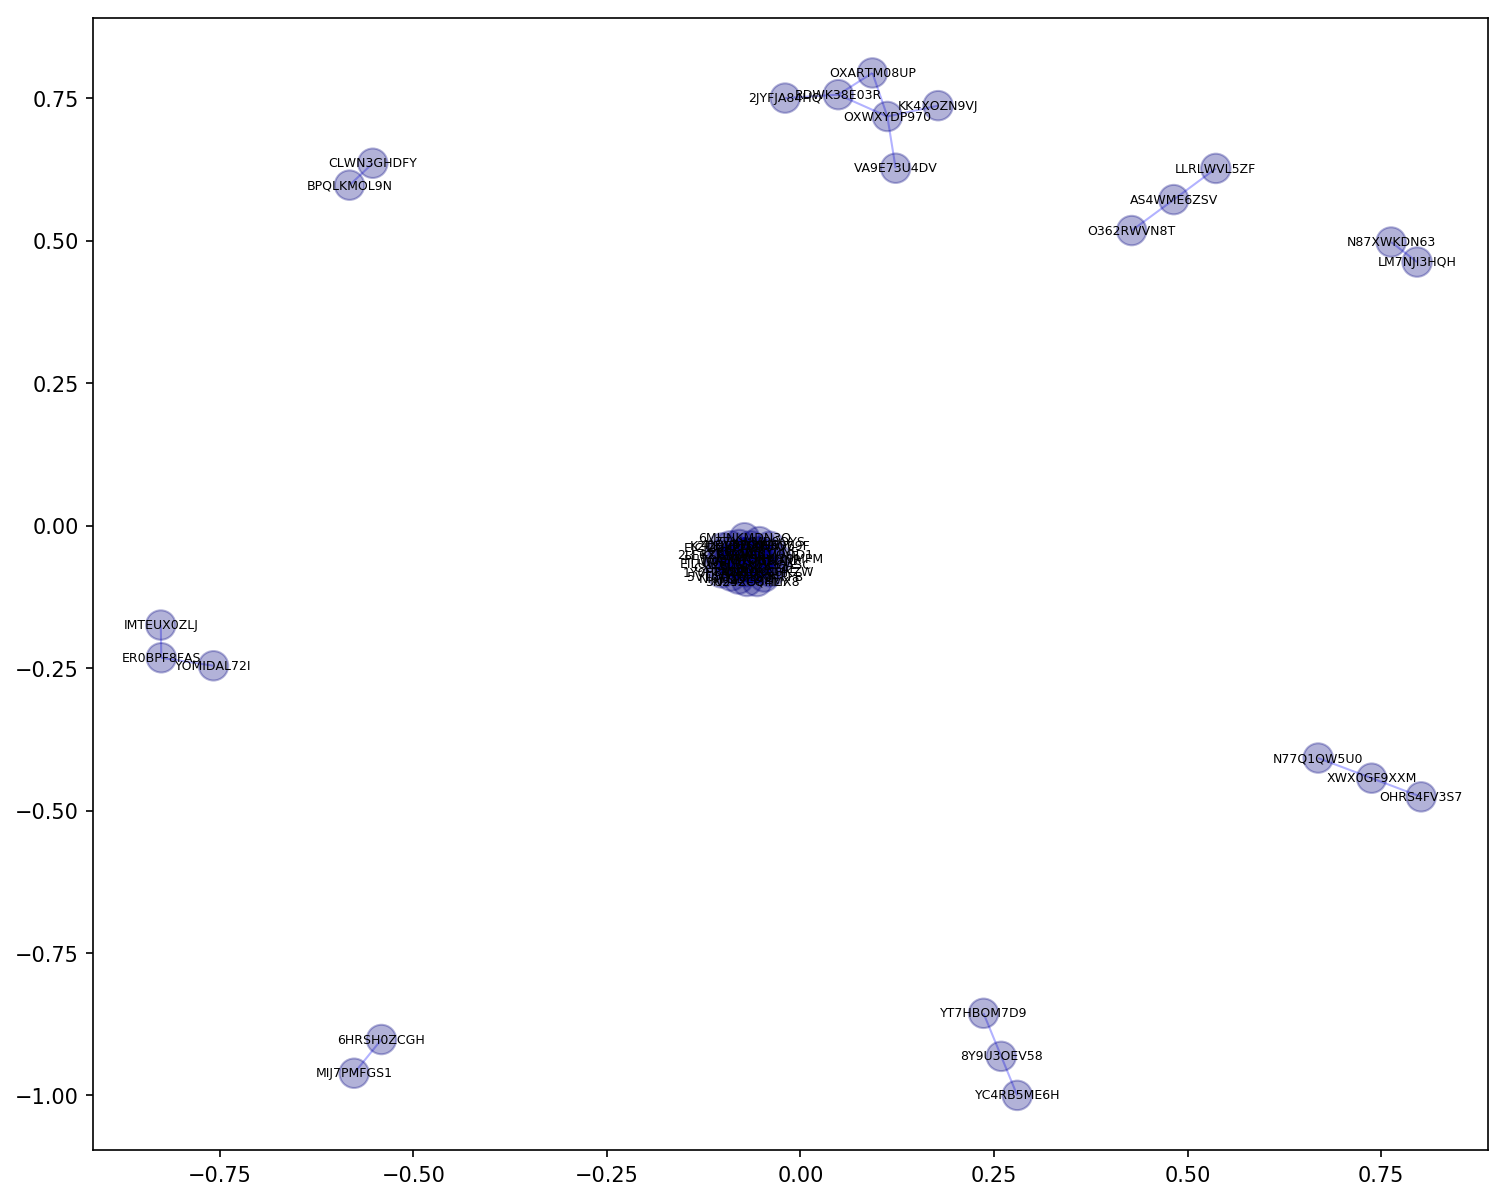

In [17]:
def draw_graph(G, graph_layout='shell',
               node_size=200, node_color='blue', node_alpha=0.3,
               node_text_size=6,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif', draw_name=True):

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color, cmap=plt.get_cmap('jet'))
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    if draw_name:
        nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                                font_family=text_font)

    plt.show()

fig = plt.figure(figsize=(12, 10), dpi=150)
ax = plt.subplot(1,1,1)

draw_graph(graph, graph_layout="spring", node_color = node_colors)

## Example 3 - Closest Beacon Localization
This example places each badge near the closest beacon for each time interval. You can immediately see that the teams spent more of the time in the classrom, but head a breakout session in the afternoon (different teams went ot different rooms).

You can also see that some badges stayed at the reception area for the majority of the time - these badges belong to participants who did not show up for the event, and should therefore be removed from the analysis.

In [18]:
members_metadata_m = members_metadata.set_index('member')
beacons_metadata_b = beacons_metadata.set_index('beacon')

In [19]:
# Take the closest beacon
closest = m5cb[0].rename('beacon')

In [20]:
# Go from closest beacon to location using the metadata
locations = closest.to_frame().join(beacons_metadata_b['location'], on='beacon')

# Join people's region for sorting
locations = locations.join(members_metadata_m['region'])

# Add the region to the index
locations = locations.reset_index().set_index(['datetime', 'region', 'member']).sort_index()

locations = locations['location']
locations.head()

datetime                   region  member    
2019-06-01 00:00:00-04:00  Team1   2CJG5KK4I9    Cafe
                                   2JYFJA84HQ    Cafe
                                   3G3F81BBVO    Cafe
                                   5VTQOYMDXP    Cafe
                                   6FI0Z5BPM9    Cafe
Name: location, dtype: object

In [21]:
def time_location_plot(time_locations, ax=None, cmap=None, freq='30min', datetime_format='%H:%M'):
    """Plots the location of individuals/groups of individuals as a function of time.
    
    Parameters
    ----------
    time_locations : pd.Series
        The locations, indexed by 'datetime' and another index (e.g. member, group, ...).
    
    ax : matplotlib axes
        The axes on which to plot.
    
    cmap : matplotlib.colors.Colormap or str
        The colormap used by matplotlib.
    
    freq : str
        The frequency of ticks on the x-axis.  Defaults to '30min'.
    
    datetime_format : str
        The way time is formatted with `strftime` on the x-axis.
        See https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior
        for more information.
    """

    # Pivot the dataframe to have datetime vs member
    pivoted = time_locations.unstack(0)

    # The list of locations
    locations = sorted(set(time_locations))
    N = len(locations)

    # Select a colormap (either passed, string or default)
    if cmap is None:
        cmap = plt.get_cmap('tab10')  # Default colormap
    elif type(cmap) is str:
        cmap = plt.get_cmap(cmap)

    if ax is None:
        ax = plt.gca()  # Use current axes if none were provided

    # Construct a colormap based on `cmap` that matches the number of different locations,
    # and displays `None` as white
    cmap = mpl.colors.ListedColormap([(1.0, 1.0, 1.0)] + list(cmap.colors), N=N+1)

    # Map locations to integers, to be used by `pcolor`
    mapping = {loc: i+1 for (i, loc) in enumerate(locations)}
    pivoted = pivoted.applymap(lambda x: mapping.get(x, 0))

    # Create the time-location diagram
    coll = ax.pcolormesh(pivoted, cmap=cmap)

    # Vertical axis, with the people
    ax.set_yticks(np.arange(0.5, len(pivoted.index), 1))
    ax.set_yticklabels(pivoted.index)

    # Horizontal axis, with the dates
    xlabels = pd.date_range(pivoted.columns[0], pivoted.columns[-1], freq=freq)
    ax.set_xticks([pivoted.columns.get_loc(idx, method='nearest') for idx in xlabels])
    ax.set_xticklabels(xlabels.strftime(datetime_format), rotation=45, ha='right')

    # Add a colorbar, with one tick per location
    cbar = ax.figure.colorbar(coll, use_gridspec=False,
                              anchor=(-.2, 0.5), aspect=30,
                              boundaries=np.arange(0, N+1)+.5)
    cbar.set_ticks(np.arange(1., N+1, 1.))
    cbar.set_ticklabels(locations)

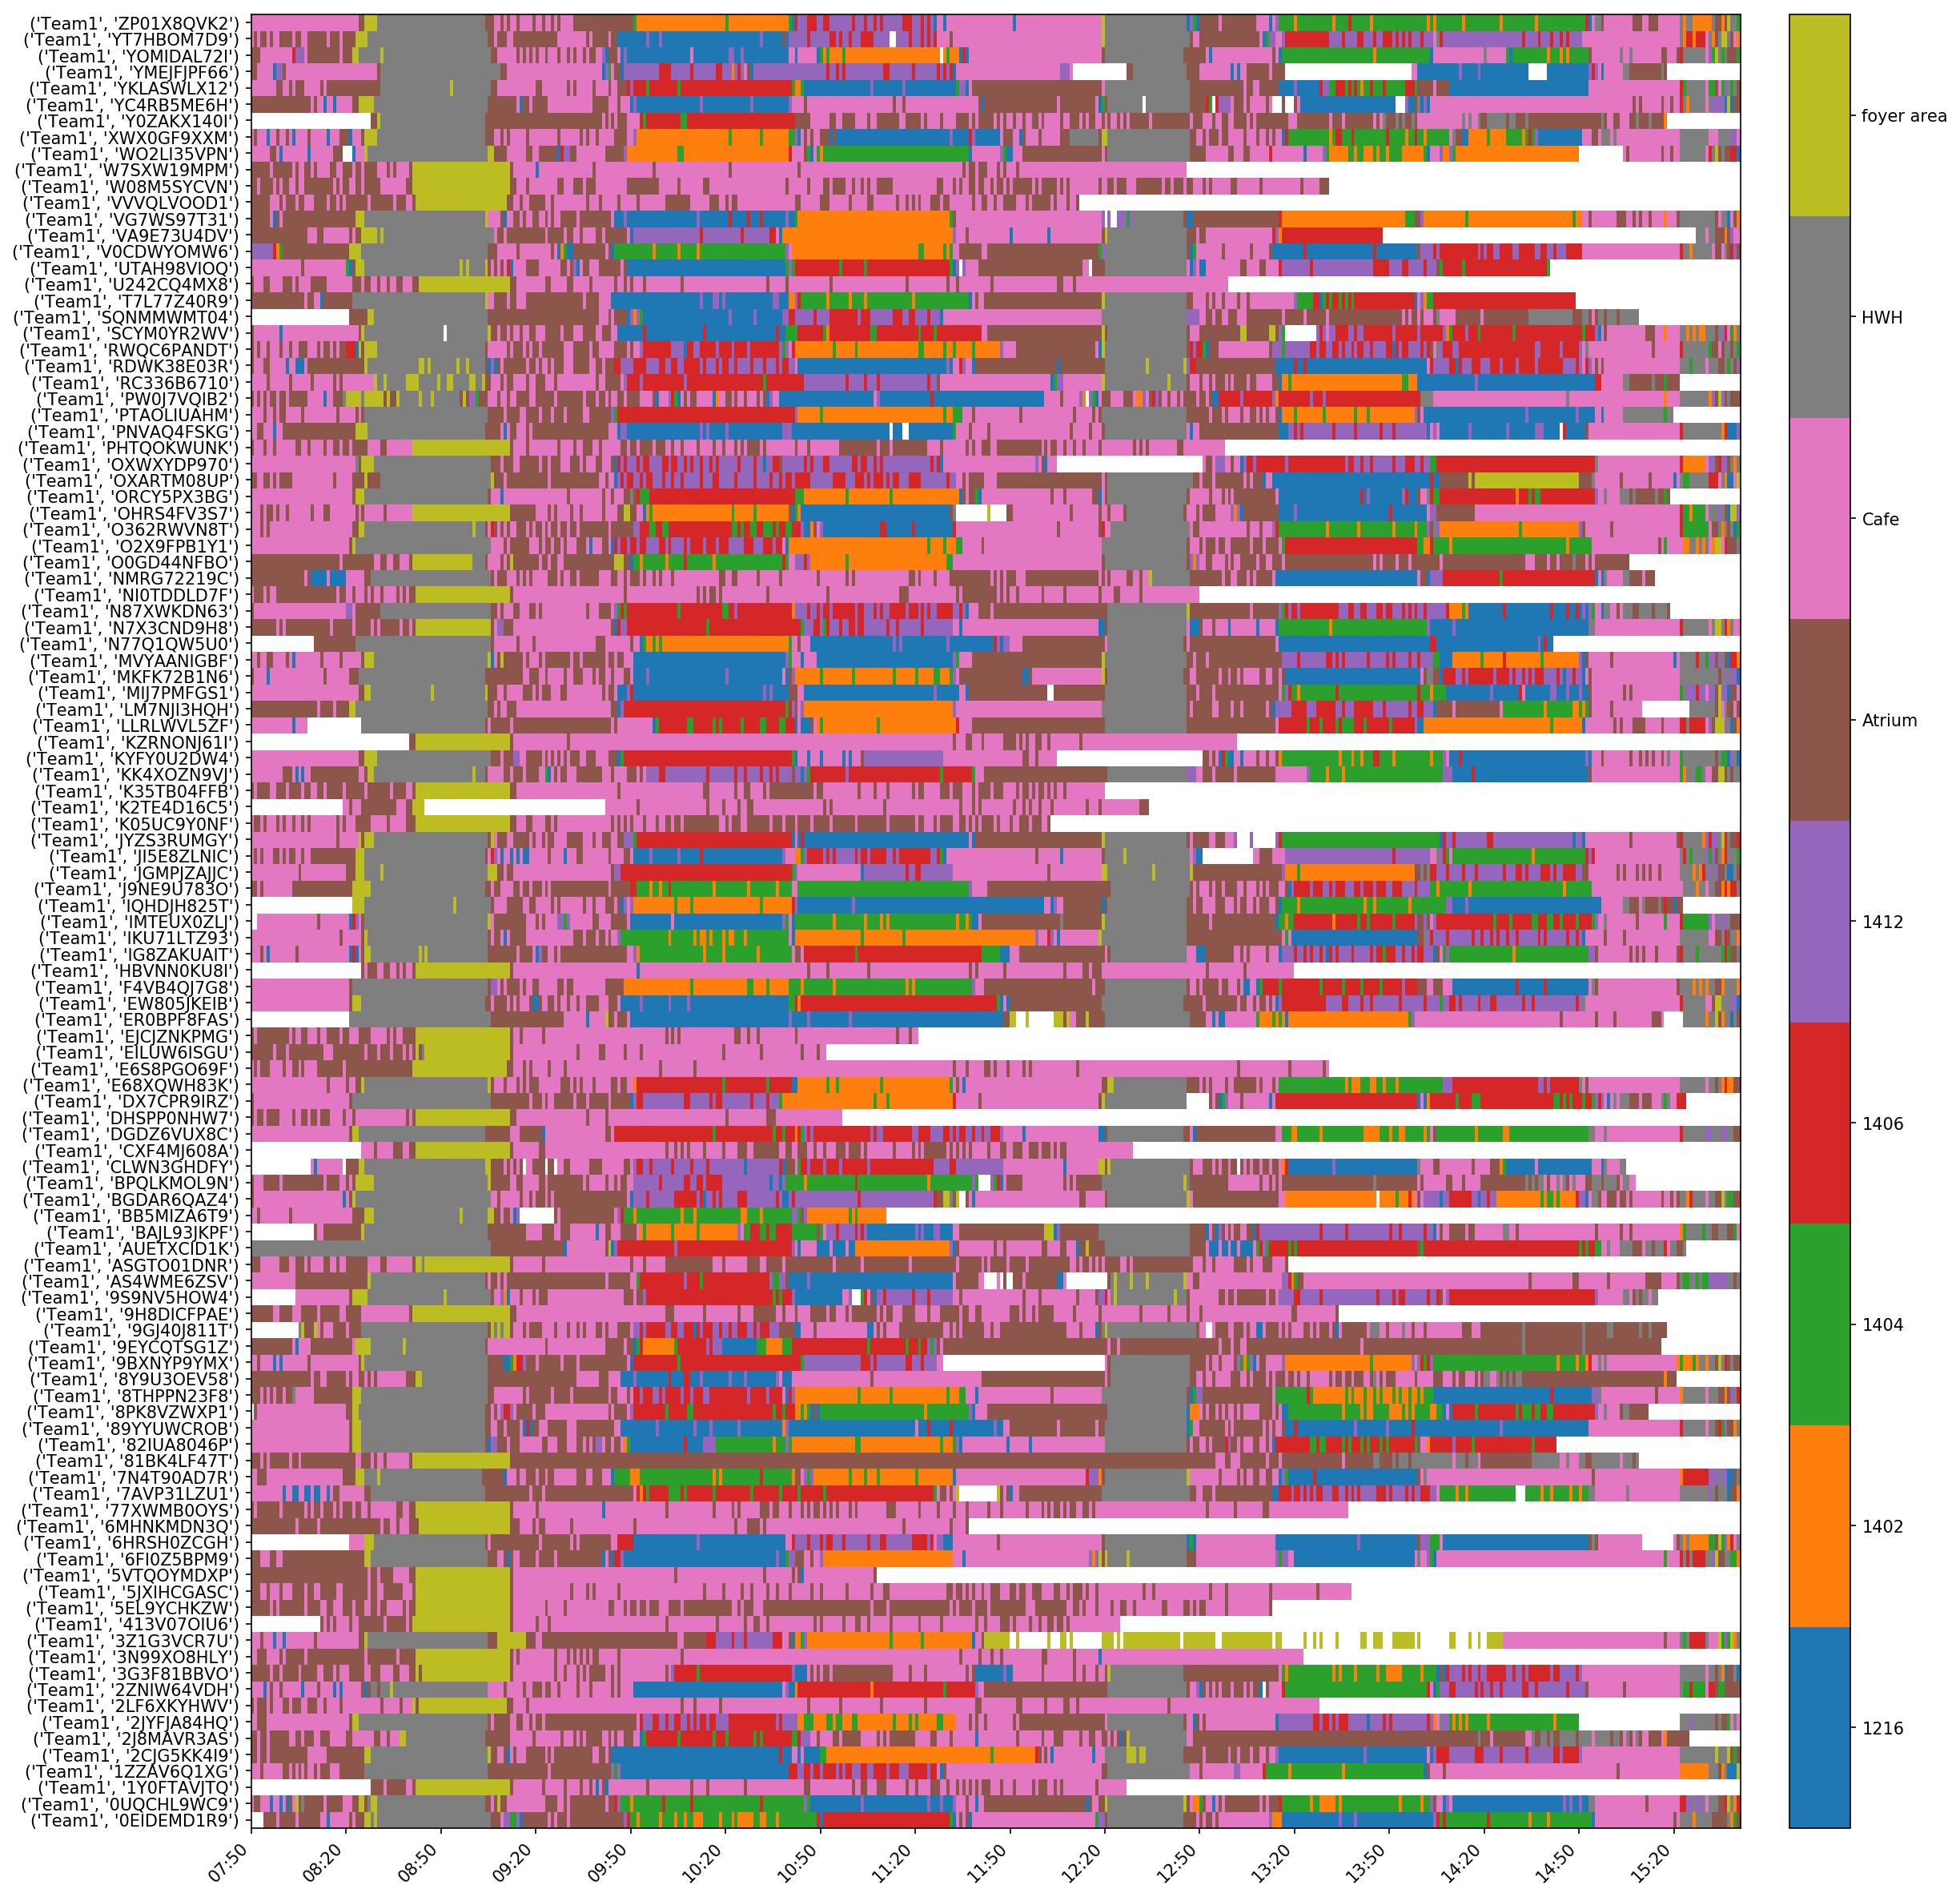

In [22]:
# The time slice for displaying the heatmap
time_slice = slice('2019-06-01 07:50', '2019-06-01 15:40')

# Plotting
fig = plt.figure(figsize=(20, 20), dpi=150)
ax = plt.subplot(1,1,1)

time_location_plot(locations.loc[time_slice])

plt.show()

# Cleaning Closest Beacon Plot

In [23]:
breakout1 = slice('2019-06-01 09:50', '2019-06-01 10:39')
breakout2 = slice('2019-06-01 10:40', '2019-06-01 11:30')
breakout3 = slice('2019-06-01 13:10', '2019-06-01 13:59')
breakout4 = slice('2019-06-01 14:00', '2019-06-01 14:50')

df_locations1 = locations[breakout1].reset_index()
df_locations2 = locations[breakout2].reset_index()
df_locations3 = locations[breakout3].reset_index()
df_locations4 = locations[breakout4].reset_index()

df_location_list = [df_locations1, df_locations2, df_locations3, df_locations4]

member_keys = set(pd.DataFrame(locations).reset_index()['member'].unique())

location_dict1 = dict()
location_dict2 = dict()
location_dict3 = dict()
location_dict4 = dict()
for i in member_keys:
    location_dict1.setdefault(i, [])
    location_dict2.setdefault(i, [])
    location_dict3.setdefault(i, [])
    location_dict4.setdefault(i, [])


location_dict_list = [location_dict1, location_dict2, location_dict3, location_dict4]

for i in range(4):
    for rows in df_location_list[i].iterrows():
        tmp_key = rows[1][2]
        tmp_room = rows[1][3]
        location_dict_list[i][tmp_key].append(tmp_room)


In [24]:
tmp = dict()
for i in member_keys:
    tmp.setdefault(i, [])
cleaned_dict_list = [tmp]*4

for i in range(4):
    
    tmp_dict = location_dict_list[i]
    
    for member in list(member_keys):
        member_hist = tmp_dict[member]
        c = Counter(member_hist)
        
        if len(c.most_common(1)) > 0:
            if c.most_common(1)[0][1] < 12:
                continue        
            cleaned_dict_list[i][member].append(c.most_common(1)[0][0])

In [72]:
cleaned_dict_list[0]

{'0EIDEMD1R9': [1404, 1406, 1216, 1404],
 '0UQCHL9WC9': [1404, 1216, 1404, 1216],
 '1Y0FTAVJTQ': [u'Cafe', u'Cafe', 'Not Here', 'Not Here'],
 '1ZZAV6Q1XG': [1216, 1406, 1404, u'Cafe'],
 '2CJG5KK4I9': [1216, 1402, 1216, 1412],
 '2J8MAVR3AS': [1406, u'Cafe', u'Atrium', u'Atrium'],
 '2JYFJA84HQ': [1406, 1402, 1412, 1404],
 '2LF6XKYHWV': [u'Cafe', u'Cafe', u'Cafe', 'Not Here'],
 '2ZNIW64VDH': [1216, 1406, 1404, 1412],
 '3G3F81BBVO': [1406, u'Atrium', 1404, 1406],
 '3N99XO8HLY': [u'Cafe', u'Cafe', u'Cafe', 'Not Here'],
 '3Z1G3VCR7U': [u'Atrium', 1402, u'foyer area', u'Cafe'],
 '413V07OIU6': [u'Cafe', u'Cafe', 'Not Here', 'Not Here'],
 '5EL9YCHKZW': [u'Atrium', u'Atrium', 'Not Here', 'Not Here'],
 '5JXIHCGASC': [u'Cafe', u'Cafe', u'Cafe', 'Not Here'],
 '5VTQOYMDXP': [u'Cafe', u'Cafe', 'Not Here', 'Not Here'],
 '6FI0Z5BPM9': [1216, 1402, 1216, u'Cafe'],
 '6HRSH0ZCGH': [1216, 1412, 1216, 1216],
 '6MHNKMDN3Q': [u'Cafe', u'Cafe', 'Not Here', 'Not Here'],
 '77XWMB0OYS': [u'Cafe', u'Cafe', u'Cafe'

In [25]:
cleaned_locations = locations.copy()

# Cleaning first breakout session
for t in range(50):
    if t < 10:
        start1 = '2019-06-01 09:{}:00-04:00'.format(50+t)
    else:
        start1 = '2019-06-01 10:{}:00-04:00'.format(t-10)
    
    for member in cleaned_dict_list[0].keys():
        cleaned_locations[start1]['Team1'][member]=cleaned_dict_list[0][member][0]
        
# Cleaning second breakout session
for t in range(51):
    if t < 20:
        start1 = '2019-06-01 10:{}:00-04:00'.format(40+t)
    else:
        start1 = '2019-06-01 11:{}:00-04:00'.format(t-20)
    
    for member in cleaned_dict_list[0].keys():
        if len(cleaned_dict_list[0][member]) > 1:
            cleaned_locations[start1]['Team1'][member]=cleaned_dict_list[0][member][1]
        
# Cleaning second breakout session
for t in range(50):
    start1 = '2019-06-01 13:{}:00-04:00'.format(10+t)
    
    for member in cleaned_dict_list[0].keys():
        if len(cleaned_dict_list[0][member]) > 2:
            cleaned_locations[start1]['Team1'][member]=cleaned_dict_list[0][member][2]
        
# Cleaning second breakout session
for t in range(51):
    start1 = '2019-06-01 14:{}:00-04:00'.format(t)
    
    for member in cleaned_dict_list[0].keys():
        if len(cleaned_dict_list[0][member]) > 3:
            cleaned_locations[start1]['Team1'][member]=cleaned_dict_list[0][member][3]


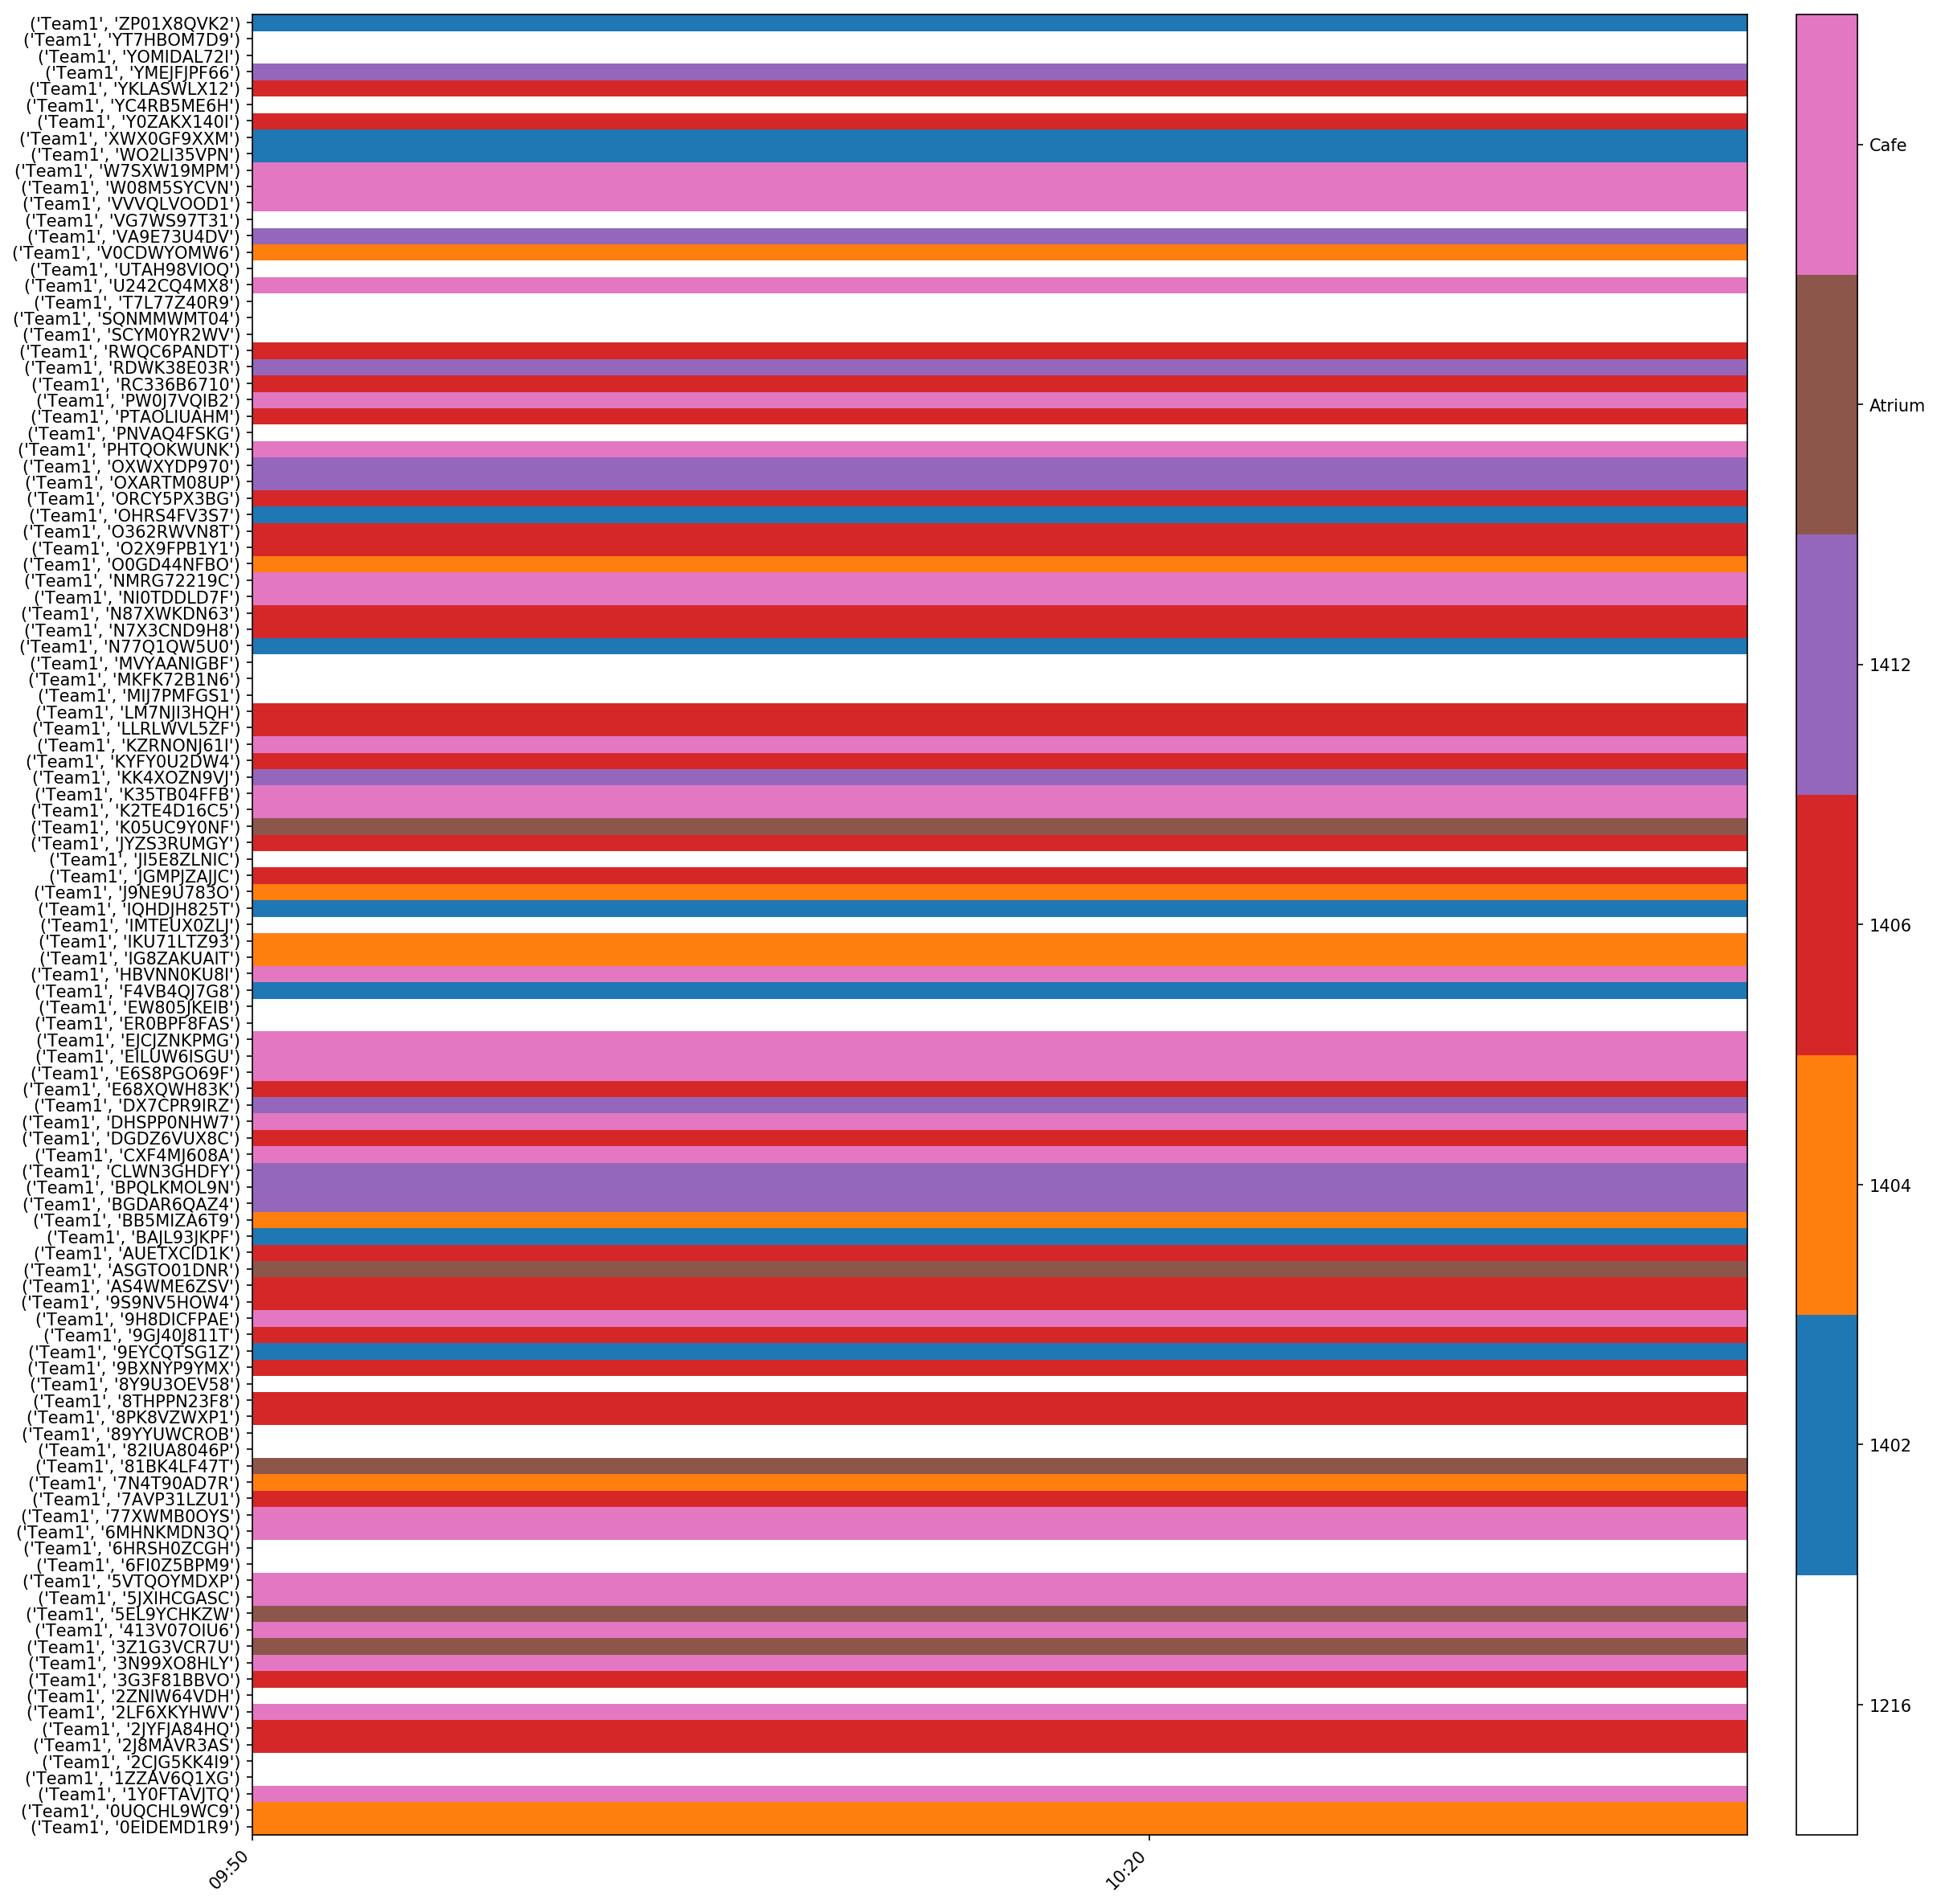

In [26]:
# The time slice for displaying the heatmap
time_slice = slice('2019-06-01 9:50', '2019-06-01 10:40')

# Plotting
fig = plt.figure(figsize=(20, 20), dpi=150)
ax = plt.subplot(1,1,1)

time_location_plot(cleaned_locations.loc[breakout1].sort_values())

plt.show()

In [27]:
for member in cleaned_dict_list[0].keys():
    if len(cleaned_dict_list[0][member]) < 4:
        add = 4 - len(cleaned_dict_list[0][member]) 
        for i in range(add):
            cleaned_dict_list[0][member].append('Not Here')

In [28]:
room_assignment1 = []
room_assignment2 = []
room_assignment3 = []
room_assignment4 = []

for row in members_metadata.iterrows():
    member = row[1][0]
    cleaned_dict_list[0].setdefault(member, ['Not Here','Not Here','Not Here','Not Here'])
    room_assignment1.append(cleaned_dict_list[0][member][0])
    room_assignment2.append(cleaned_dict_list[0][member][1])
    room_assignment3.append(cleaned_dict_list[0][member][2])
    room_assignment4.append(cleaned_dict_list[0][member][3])
    
members_metadata1 = members_metadata.copy()
members_metadata1['region'] = room_assignment1

In [29]:
cleaned_dict_list[0][member][0]

'Not Here'

In [30]:
members_metadata_m1 = members_metadata1.set_index('member')


# Go from closest beacon to location using the metadata
locations1 = closest.to_frame().join(beacons_metadata_b['location'], on='beacon')

# Join people's region for sorting
locations1 = locations1.join(members_metadata_m1['region'])

# Add the region to the index
locations1 = locations1.reset_index().set_index(['datetime', 'region', 'member']).sort_index()

locations1 = locations1['location']

cleaned_locations = locations1.copy()

# Cleaning first breakout session
for t in range(50):
    if t < 10:
        start1 = '2019-06-01 09:{}:00-04:00'.format(50+t)
    else:
        start1 = '2019-06-01 10:{}:00-04:00'.format(t-10)
    
    for member in cleaned_dict_list[0].keys():
        cleaned_locations[start1][:][member]=cleaned_dict_list[0][member][0]
        
# Cleaning second breakout session
for t in range(51):
    if t < 20:
        start1 = '2019-06-01 10:{}:00-04:00'.format(40+t)
    else:
        start1 = '2019-06-01 11:{}:00-04:00'.format(t-20)
    
    for member in cleaned_dict_list[0].keys():
        if len(cleaned_dict_list[0][member]) > 1:
            cleaned_locations[start1][:][member]=cleaned_dict_list[0][member][1]
        
# Cleaning second breakout session
for t in range(50):
    start1 = '2019-06-01 13:{}:00-04:00'.format(10+t)
    
    for member in cleaned_dict_list[0].keys():
        if len(cleaned_dict_list[0][member]) > 2:
            cleaned_locations[start1][:][member]=cleaned_dict_list[0][member][2]
        
# Cleaning second breakout session
for t in range(51):
    start1 = '2019-06-01 14:{}:00-04:00'.format(t)
    
    for member in cleaned_dict_list[0].keys():
        if len(cleaned_dict_list[0][member]) > 3:
            cleaned_locations[start1][:][member]=cleaned_dict_list[0][member][3]


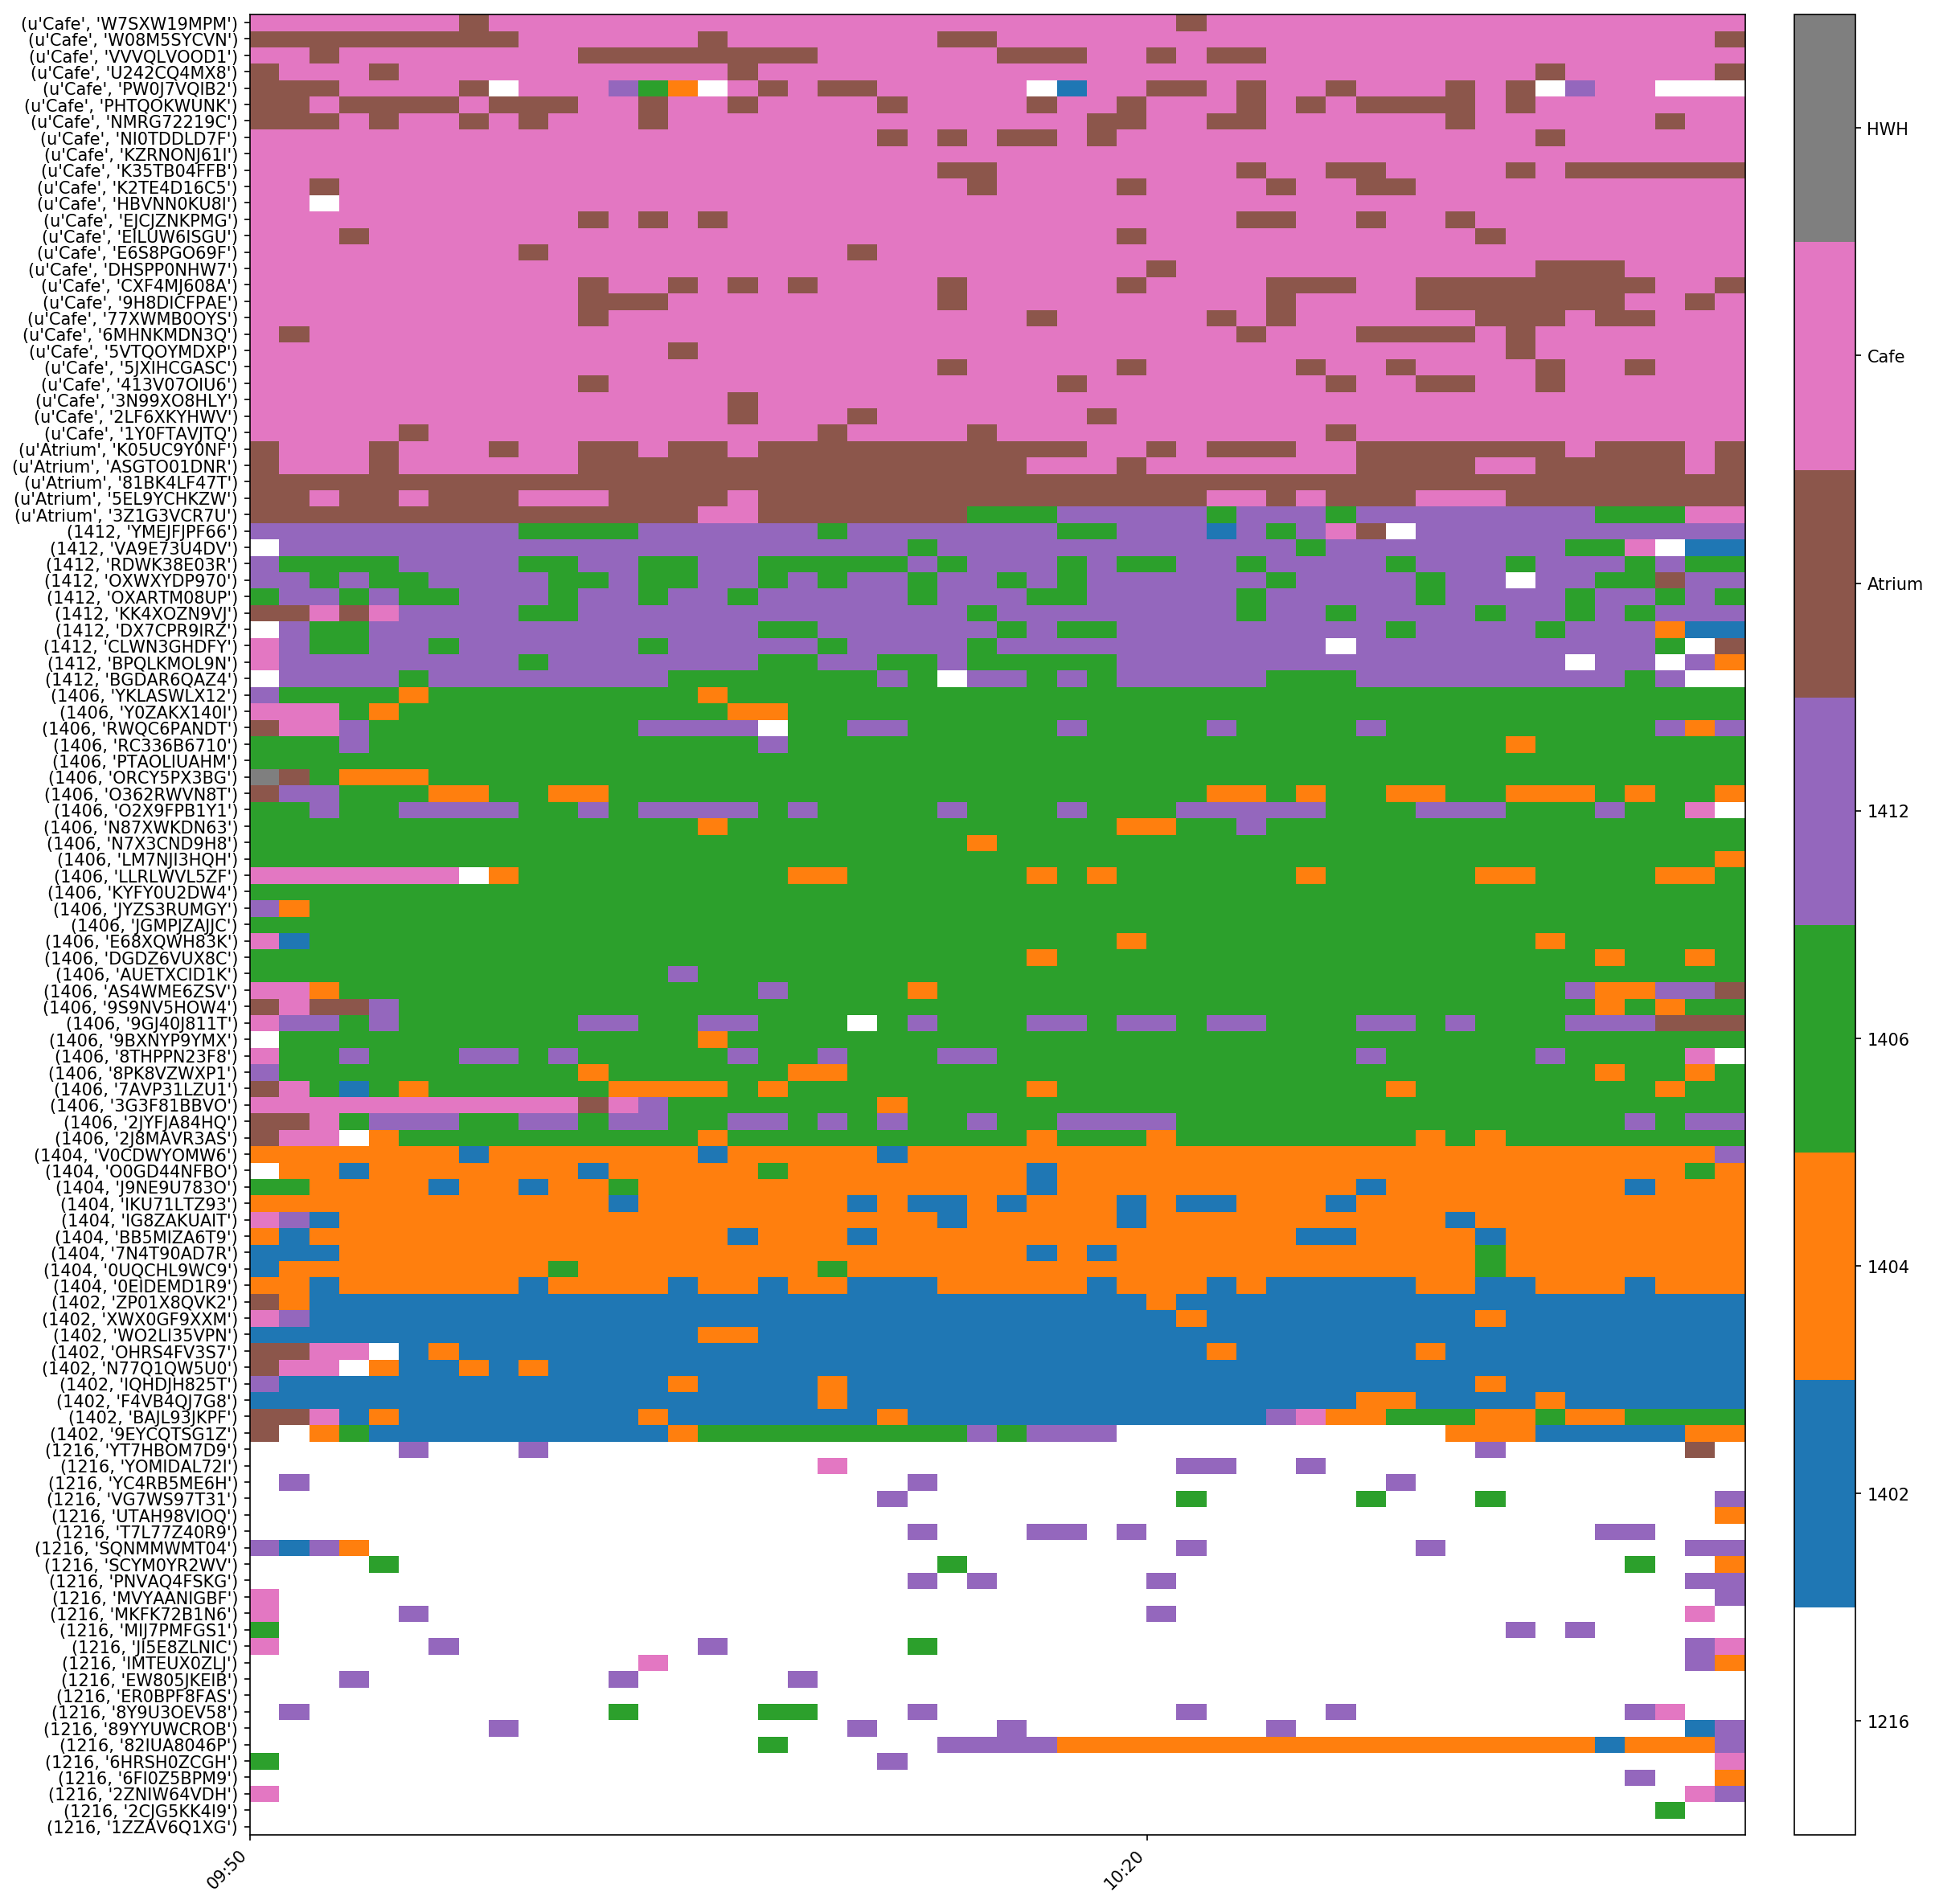

In [31]:
# The time slice for displaying the heatmap
time_slice = slice('2019-06-01 9:50', '2019-06-01 10:40')

# Plotting
fig = plt.figure(figsize=(20, 20), dpi=150)
ax = plt.subplot(1,1,1)

time_location_plot(cleaned_locations.loc[breakout1].sort_values())

plt.show()

In [32]:
tmp_m2ms_sorted = tmp_m2ms.sort_index(0,0)

# Filter data from specific time period

m2m_breakout1 = tmp_m2ms_sorted.loc[breakout1]

# keep only instances with strong signal
m2m_filter_rssi1 = m2m_breakout1[m2m_breakout1.rssi >= -62].copy()
print(len(m2m_filter_rssi1))

17974


In [33]:
# Count number of time members were in close proximity
# We name the count column "weight" so that networkx will use it as weight for the spring layout
m2m_edges1 = m2m_filter_rssi1.groupby(['member1', 'member2'])[['rssi_weighted_mean']].count().rename(columns={'rssi_weighted_mean':'weight'})
m2m_edges1 = m2m_edges1[["weight"]].reset_index()

# Keep strongest edges (threshold set manually)
m2m_edges1 = m2m_edges1[m2m_edges1.weight > 1]
print(len(m2m_edges1))

# Create a graph
graph1=nx.from_pandas_edgelist(m2m_edges1, "member1", "member2", "weight")

420


In [34]:
# set colors by region
regions1 = members_metadata_m1["region"].unique()
len_regions1 = len(regions1)
value_map1 = {}
for i in range(0,len_regions1):
    value_map1[regions1[i]] = i * (1.0/(len_regions1-1))

In [35]:
# Add node information. Assign color
for index, row in members_metadata_m1.reset_index().iterrows():
    member = row["member"]
    region = row["region"]
    color = value_map1.get(region)
    if member in graph1.nodes():        
        graph1.add_node(member, region=region, color = color)
        
node_colors = [color for member,color in nx.get_node_attributes(graph1, 'color').iteritems()]

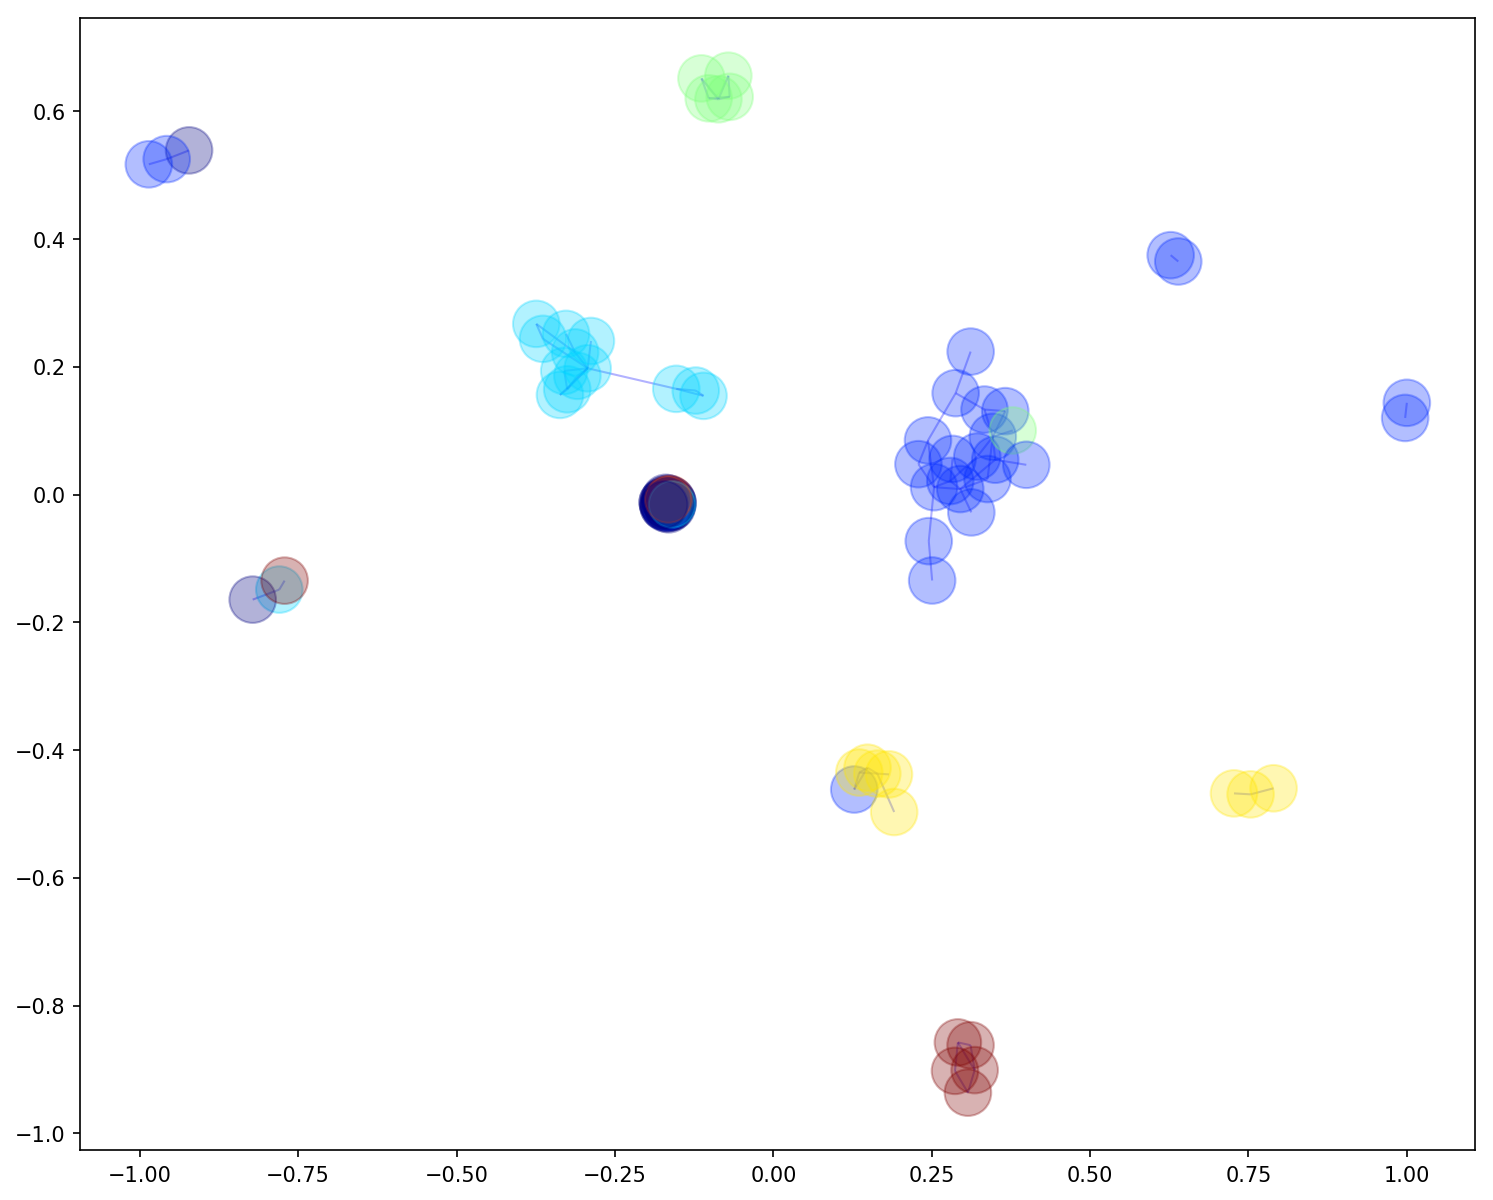

In [36]:
fig = plt.figure(figsize=(12, 10), dpi=150)
ax = plt.subplot(1,1,1)

draw_graph(graph1, graph_layout="spring", node_size=500, node_color = node_colors, draw_name=False)

**Generate Many Histograms For Breakout Sessions**

In [53]:
# create time slices
def generate_time_points(start_h, start_m, end_h, end_m, interval=5):
    time_slices = []
    start = '2019-06-01 {:02}:{:02}'.format(start_h, start_m)
    duration = (end_h - start_h) * 60 + (end_m - start_m)
    for i in range(duration/interval+1):
        if start_m < 60-interval+1:
            start_m += interval-1
        else:
            start_h += 1
            start_m = start_m - 60 + interval
        tmp_time = '2019-06-01 {:02}:{:02}'.format(start_h, start_m)
        
        time_slices.append(slice(start, tmp_time))
        
        if start_m >= 59:
            start = '2019-06-01 {:02}:{:02}'.format(start_h+1, 0)
        else:
            start_m += 1
            start = '2019-06-01 {:02}:{:02}'.format(start_h, start_m)
        
    return time_slices

In [54]:
bo1 = generate_time_points(9, 50, 10, 30)
bo2 = generate_time_points(10, 40, 11, 20)
bo3 = generate_time_points(13, 10, 13, 50)
bo4 = generate_time_points(14, 0, 14, 40)
breakout = bo1 + bo2 + bo3 + bo4

**breakout session as a whole**

In [ ]:
# freq_list = []
# for i in breakout:
#     freq_list.append(tmp_m2ms.reset_index().set_index('datetime').loc[i])

# hist_list = []
# for freq in freq_list:
#     tmp_freq = []
#     for row in freq.iterrows():
#         tmp = [row[1][3]]*int(row[1][5])
#         tmp_freq = tmp_freq + tmp
#     hist_list.append(tmp_freq)

In [ ]:
# pic_dir = "./histograms/"
# if not os.path.isdir(pic_dir):
#     os.makedirs(pic_dir)

# for j in range(1, 5): 
#     for i in range(1, 10):
#         plt.figure(figsize=(20,10))
#         plt.hist(hist_list[i-1], bins=50)
#         plt.title('breakout{}_{}'.format(j,i))
#         plt.savefig(pic_dir + 'breakout{}_{}.png'.format(j,i))

In [ ]:
# from natsort import natsorted
# from moviepy.editor import *

# base_dir = os.path.realpath('./histograms')
# print(base_dir)

# img_list = glob.glob('./histograms/*.png')  # Get all the pngs in the current directory
# img_list_sorted = natsorted(img_list, reverse=False)  # Sort the images

# clips = [ImageClip(m).set_duration(0.8)
#          for m in img_list_sorted]

# concat_clip = concatenate_videoclips(clips, method="compose")
# concat_clip.write_videofile("breakout.mp4", fps=25)

**breakout session 1**

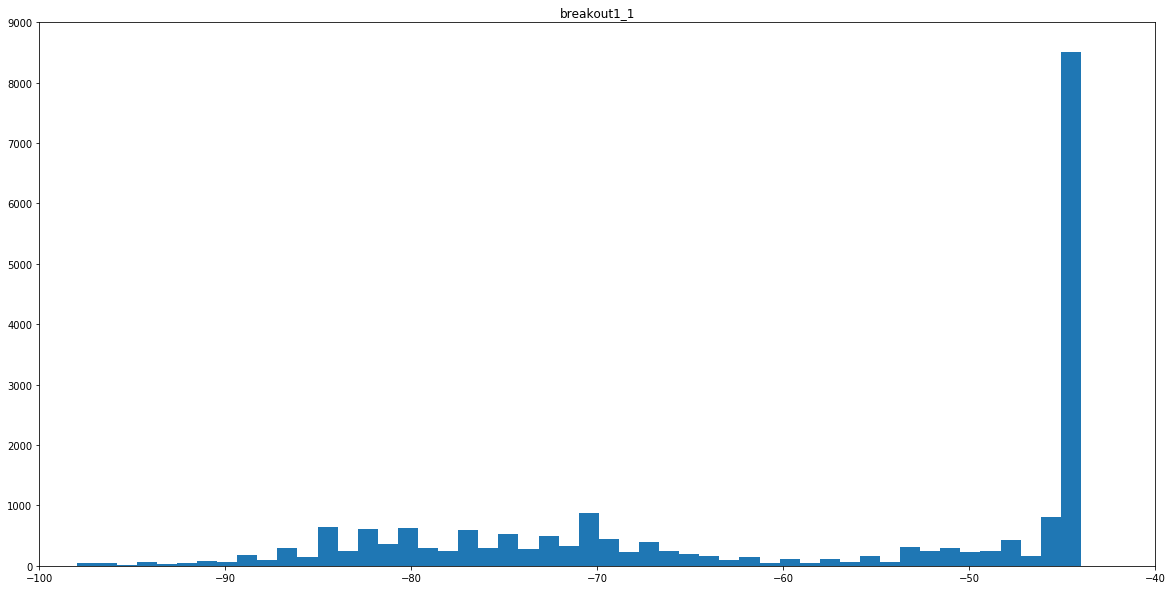

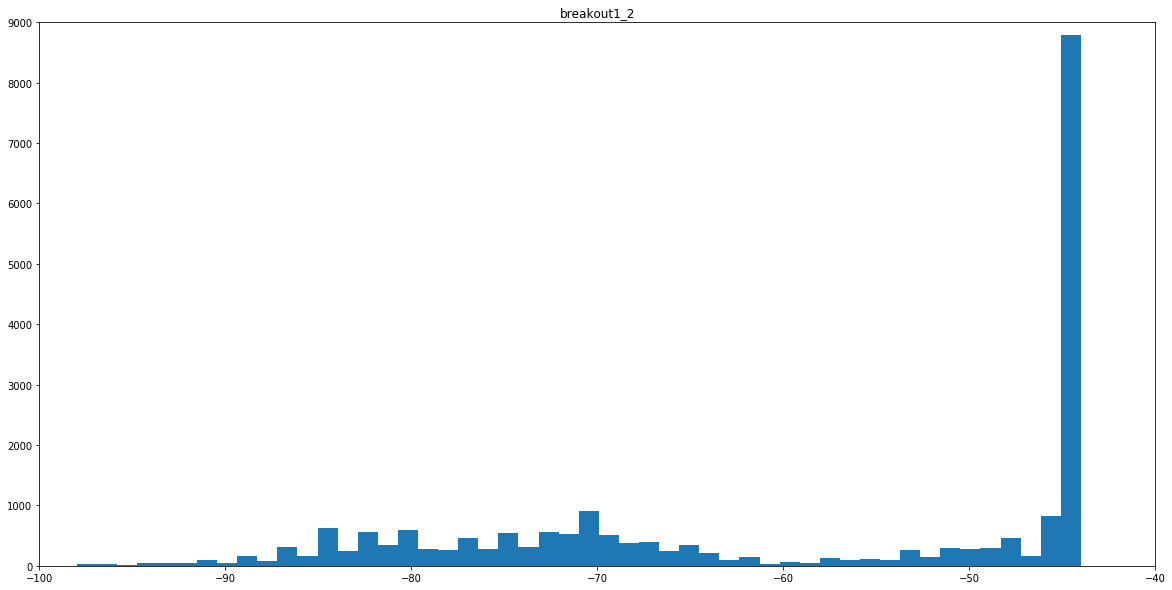

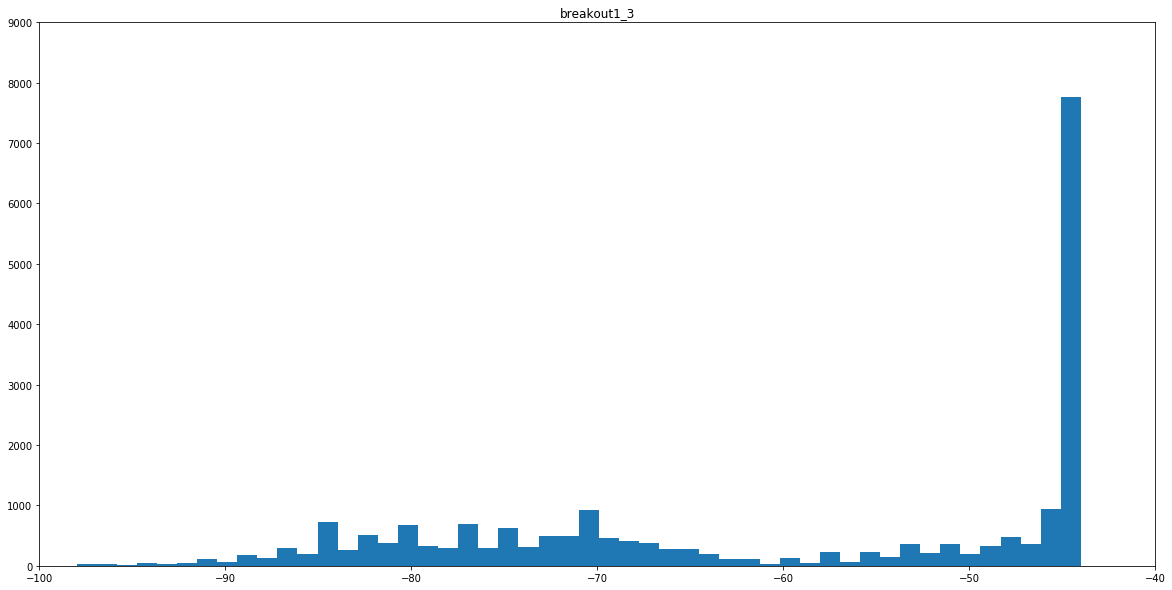

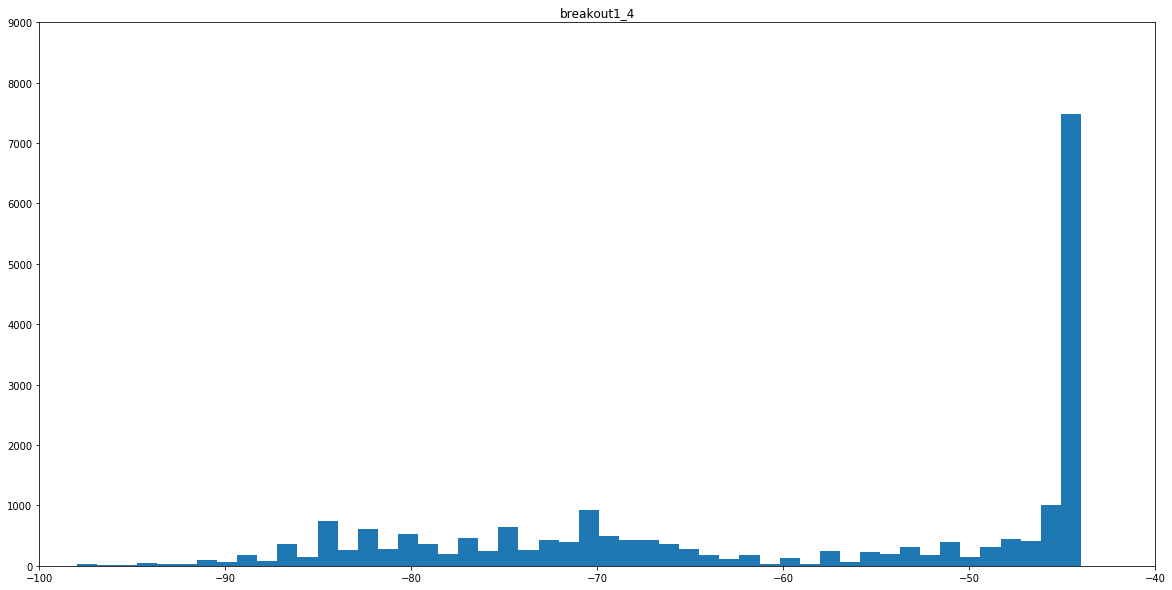

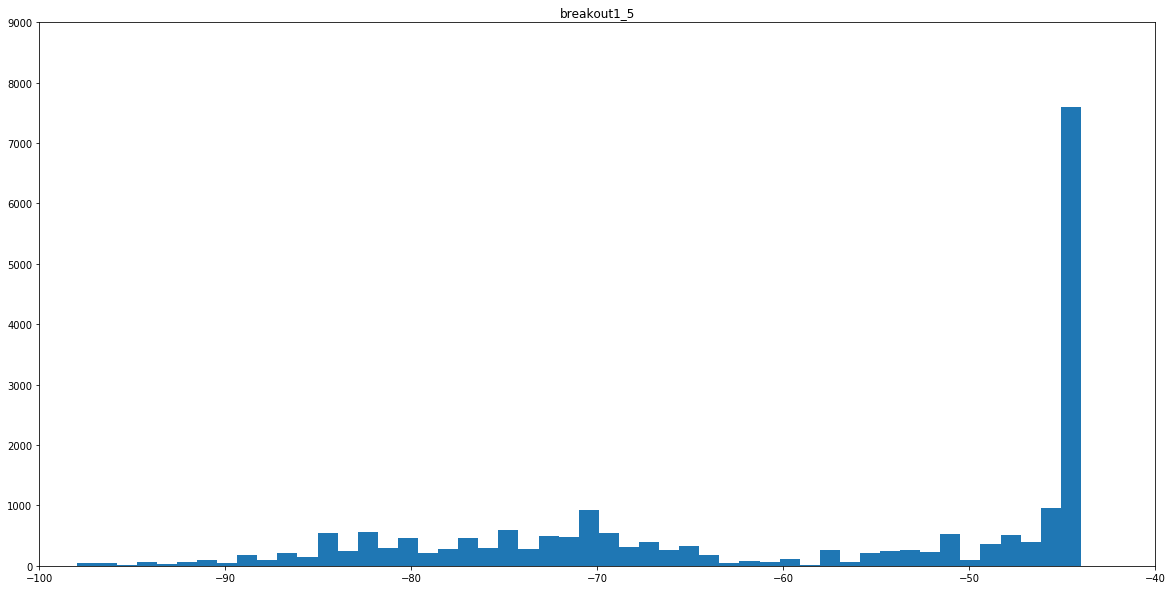

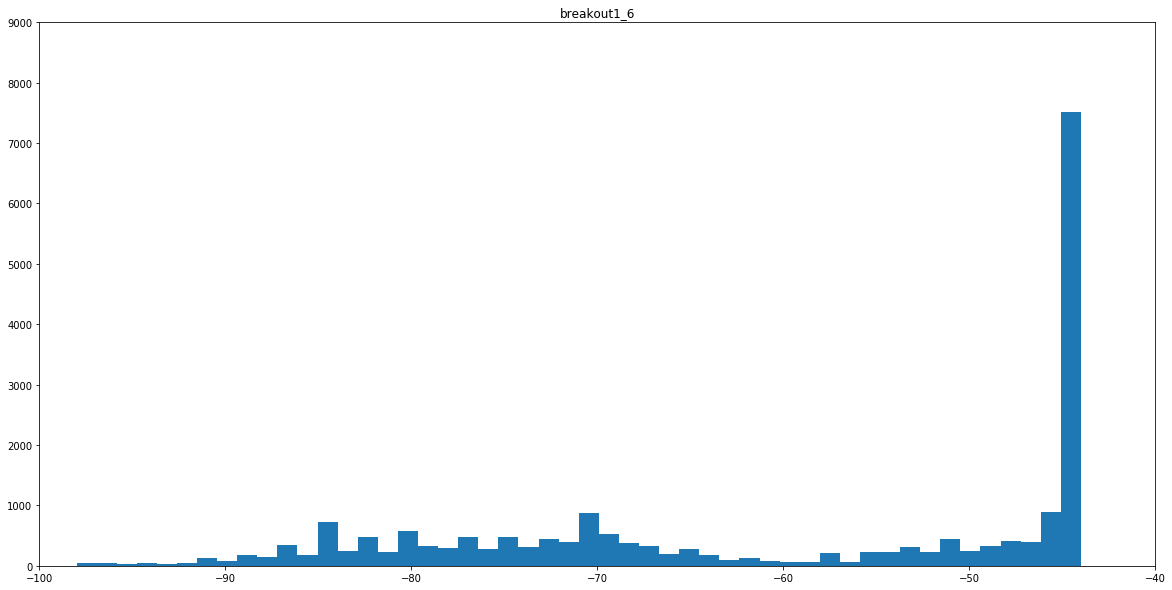

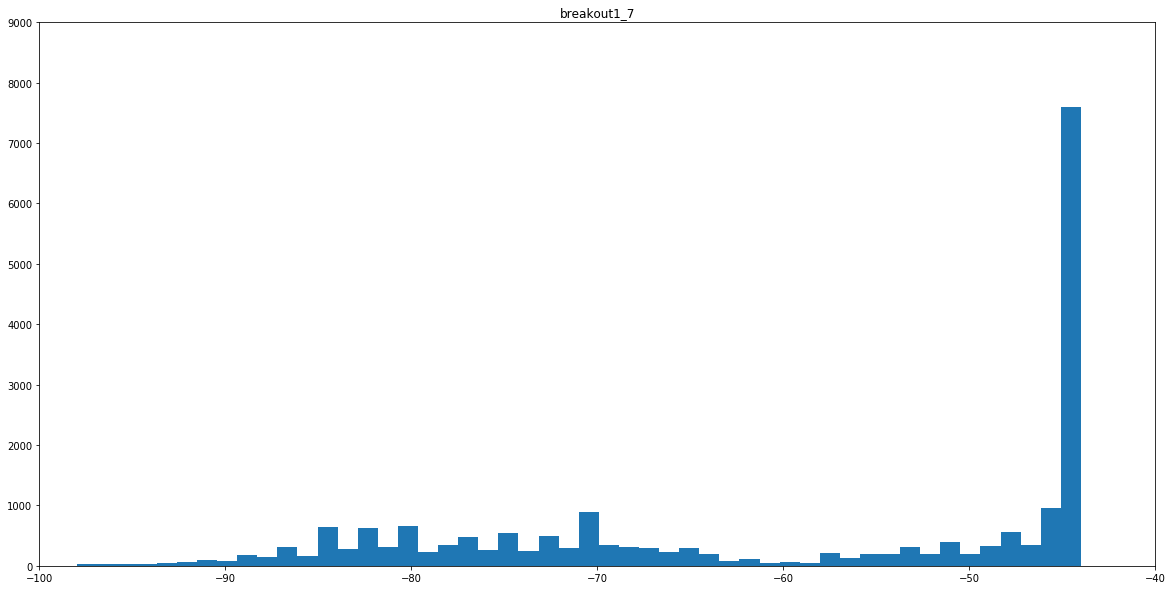

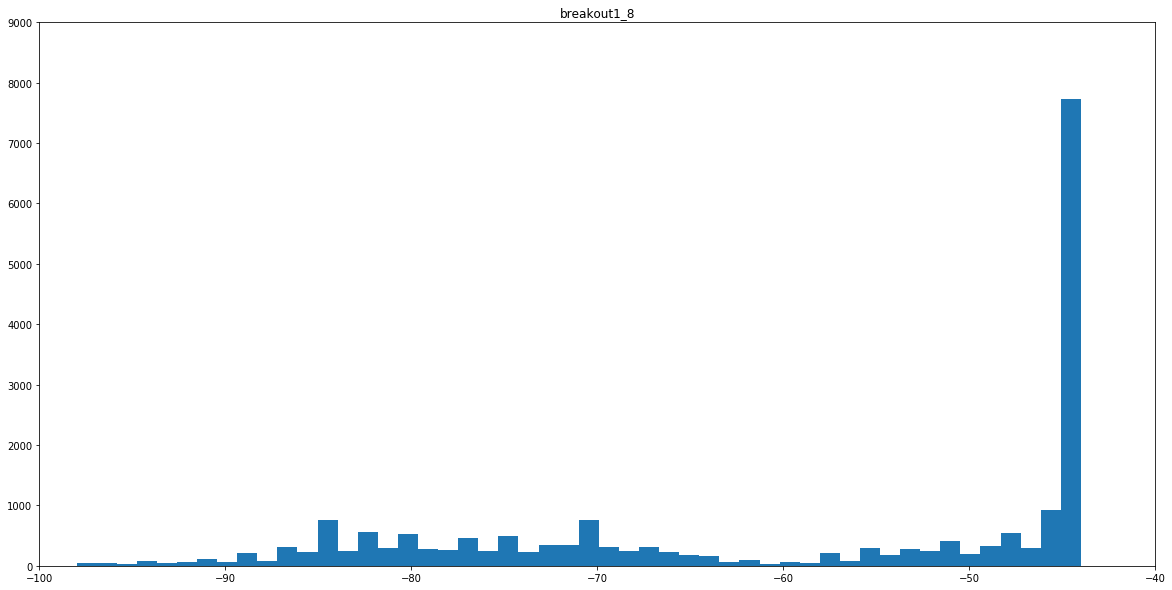

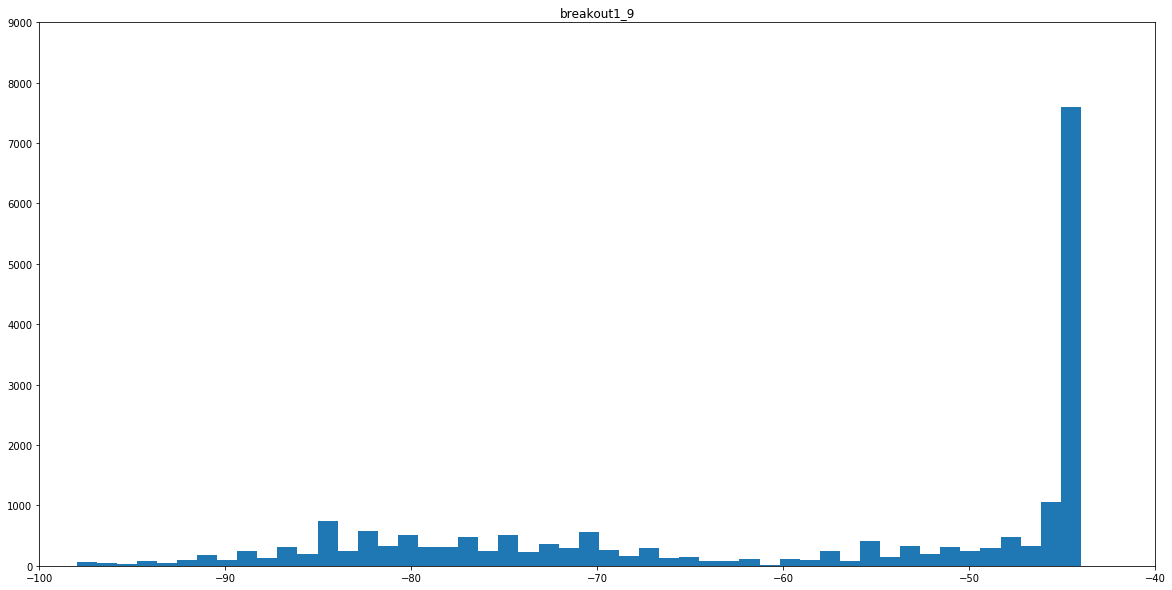

In [63]:
freq_list_1 = []
for i in bo1:
    freq_list_1.append(tmp_m2ms.reset_index().set_index('datetime').loc[i])

hist_list_1 = []
for freq in freq_list_1:
    tmp_freq = []
    for row in freq.iterrows():
        tmp = [row[1][3]]*int(row[1][5])
        tmp_freq = tmp_freq + tmp
    hist_list_1.append(tmp_freq)

pic_dir = "./histograms/breakout1/"
if not os.path.isdir(pic_dir):
    os.makedirs(pic_dir)

for i in range(1, 10):
    plt.figure(figsize=(20,10))
    plt.hist(hist_list_1[i-1], bins=50)
    plt.xlim([-100, -40])
    plt.ylim([0, 9000])
    plt.title('breakout1_{}'.format(i))
    plt.savefig(pic_dir + 'breakout1_{}.png'.format(i))

In [64]:
os.getcwd()

'/Users/songziyu/Desktop/Capstone-URMC'

In [65]:
from natsort import natsorted
from moviepy.editor import *

base_dir = os.path.realpath('./histograms/breakout1')
print(base_dir)

img_list = glob.glob('./histograms/breakout1/*.png')  # Get all the pngs in the current directory
img_list_sorted = natsorted(img_list, reverse=False)  # Sort the images

clips = [ImageClip(m).set_duration(0.8)
         for m in img_list_sorted]

concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip.write_videofile("breakout1.mp4", fps=25)

/Users/songziyu/Desktop/Capstone-URMC/histograms/breakout1


t:   0%|          | 0/180 [00:00<?, ?it/s, now=None]

Moviepy - Building video breakout1.mp4.
Moviepy - Writing video breakout1.mp4



Moviepy - Done !
Moviepy - video ready breakout1.mp4


**breakout session 2**

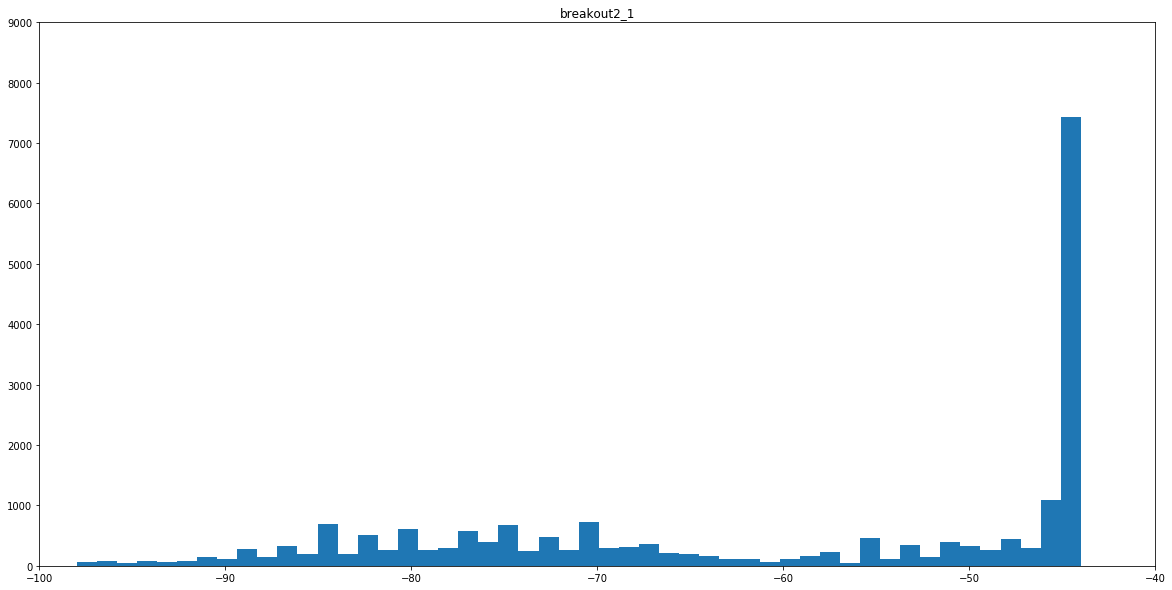

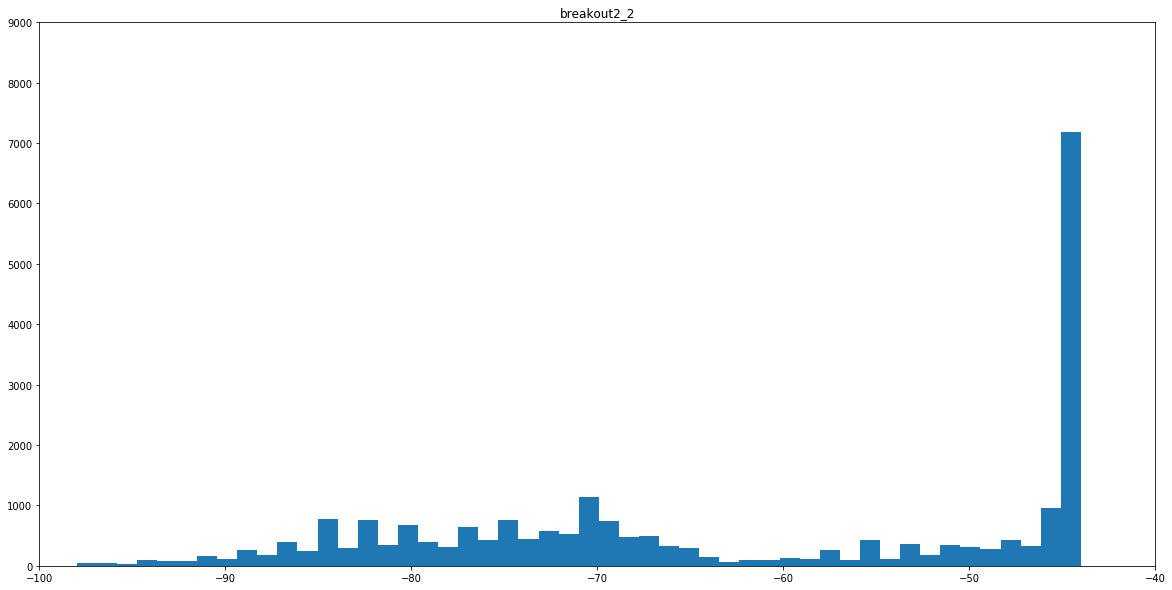

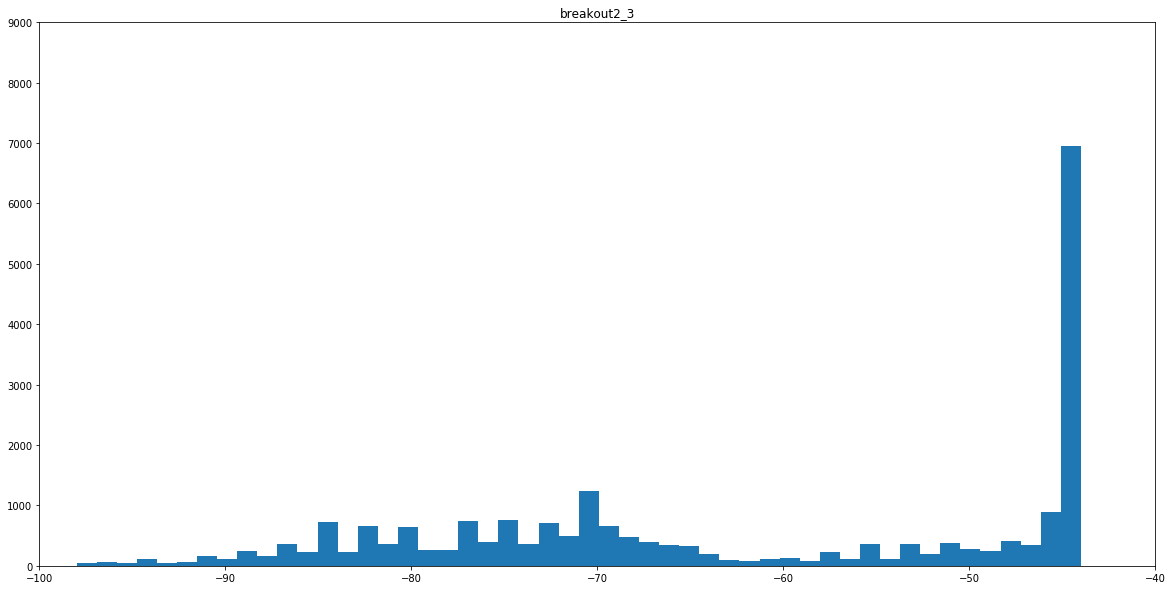

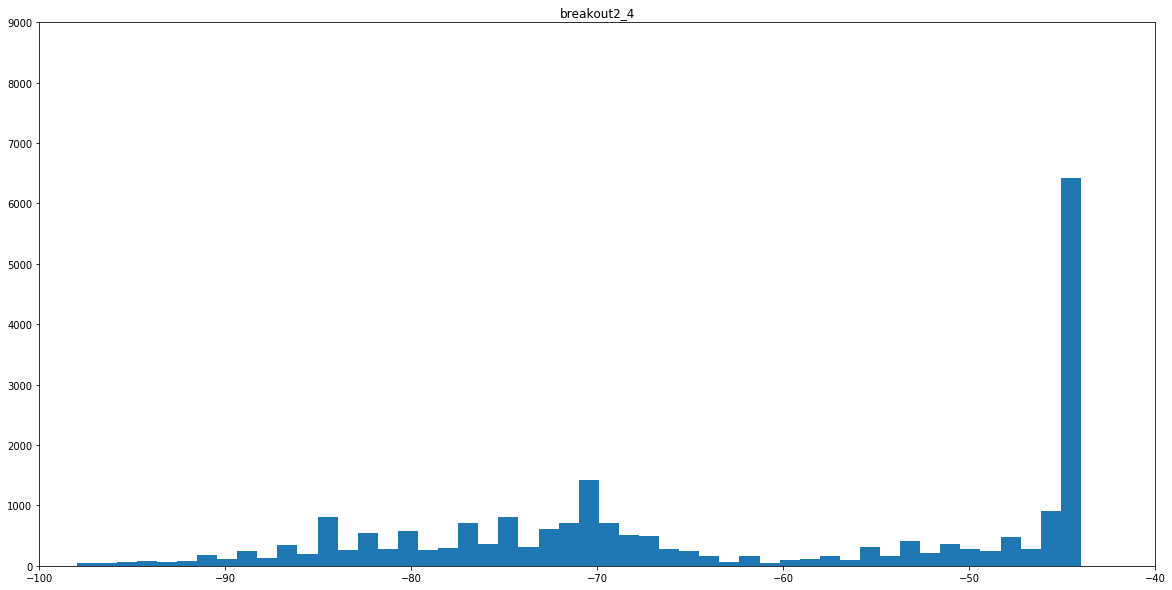

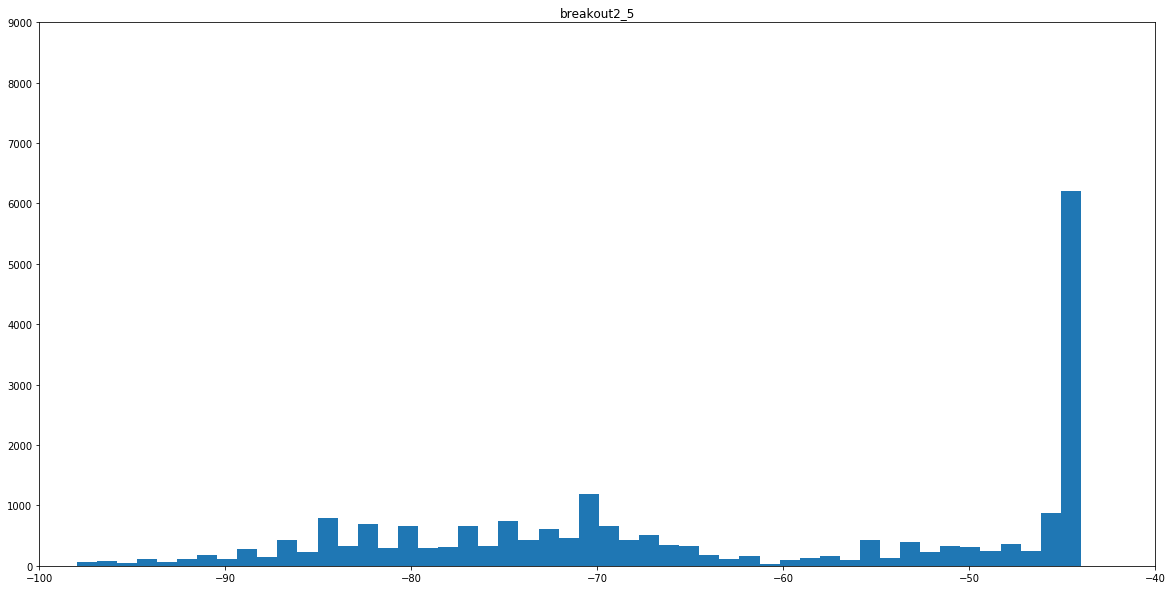

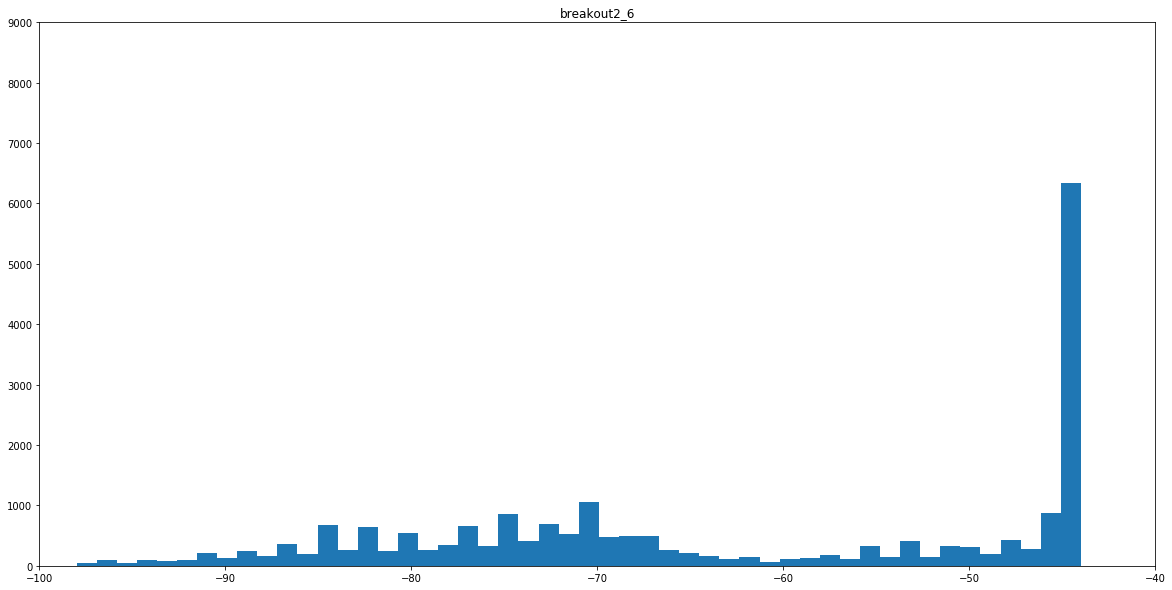

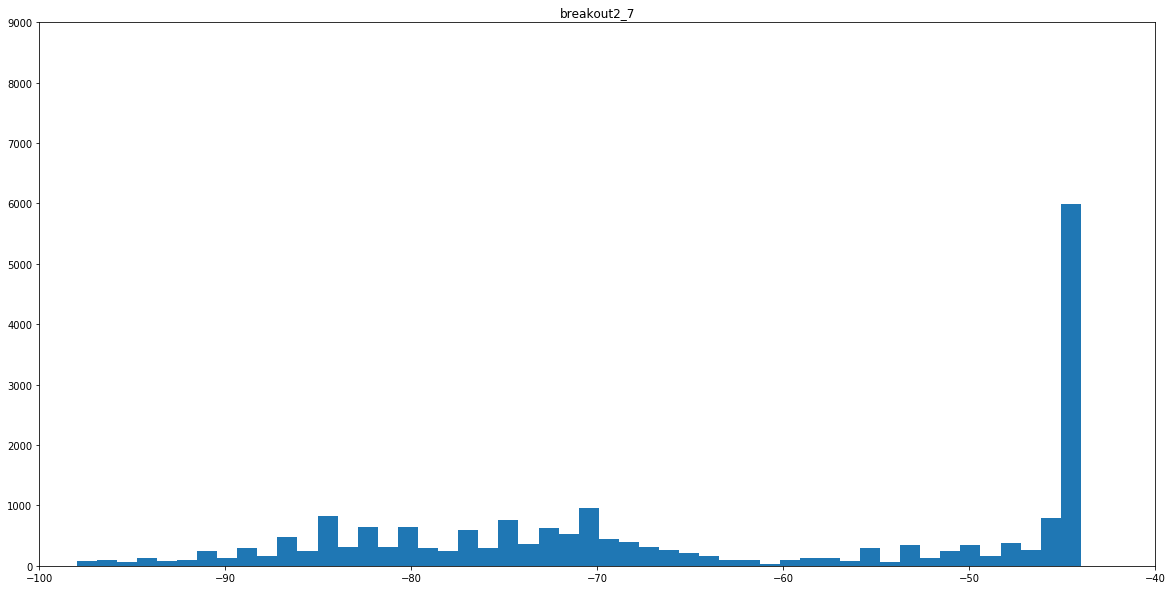

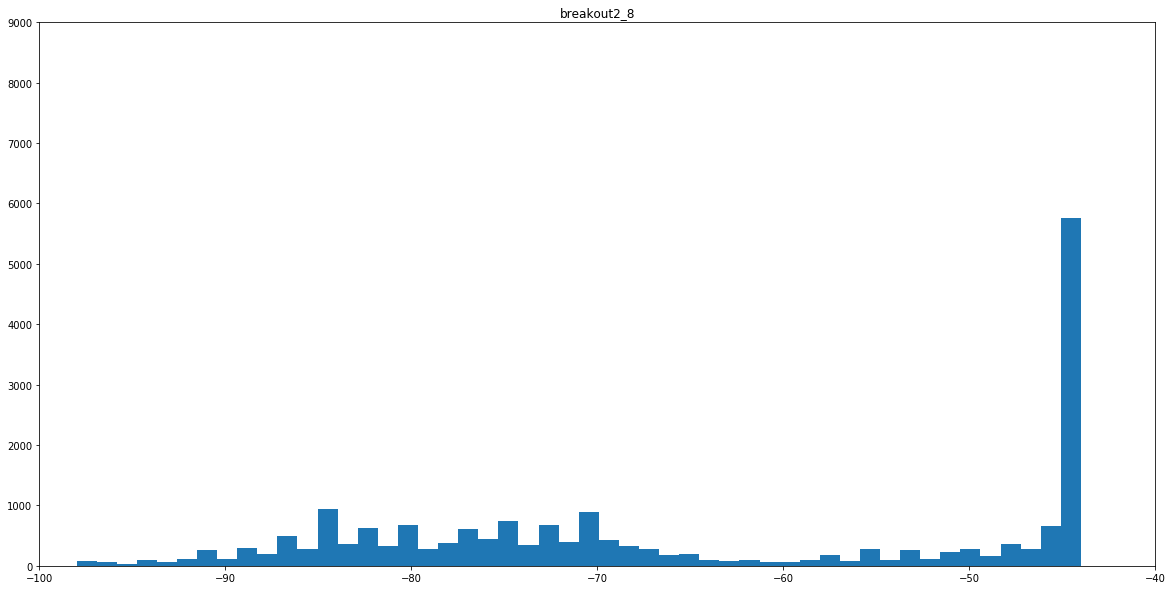

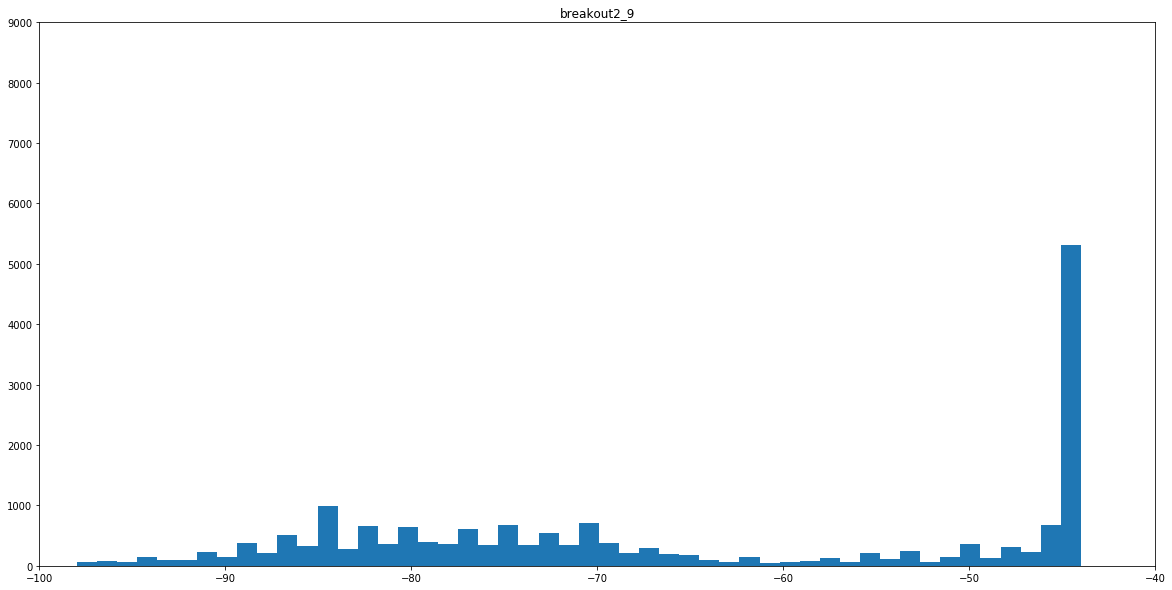

In [66]:
freq_list_2 = []
for i in bo2:
    freq_list_2.append(tmp_m2ms.reset_index().set_index('datetime').loc[i])

hist_list_2 = []
for freq in freq_list_2:
    tmp_freq = []
    for row in freq.iterrows():
        tmp = [row[1][3]]*int(row[1][5])
        tmp_freq = tmp_freq + tmp
    hist_list_2.append(tmp_freq)

pic_dir = "./histograms/breakout2/"
if not os.path.isdir(pic_dir):
    os.makedirs(pic_dir)

for i in range(1, 10):
    plt.figure(figsize=(20,10))
    plt.hist(hist_list_2[i-1], bins=50)
    plt.xlim([-100, -40])
    plt.ylim([0, 9000])
    plt.title('breakout2_{}'.format(i))
    plt.savefig(pic_dir + 'breakout2_{}.png'.format(i))

In [67]:
from natsort import natsorted
from moviepy.editor import *

base_dir = os.path.realpath('./histograms/breakout2')
print(base_dir)

img_list = glob.glob('./histograms/breakout2/*.png')  # Get all the pngs in the current directory
img_list_sorted = natsorted(img_list, reverse=False)  # Sort the images

clips = [ImageClip(m).set_duration(0.8)
         for m in img_list_sorted]

concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip.write_videofile("breakout2.mp4", fps=25)

/Users/songziyu/Desktop/Capstone-URMC/histograms/breakout2


t:   0%|          | 0/180 [00:00<?, ?it/s, now=None]

Moviepy - Building video breakout2.mp4.
Moviepy - Writing video breakout2.mp4



Moviepy - Done !
Moviepy - video ready breakout2.mp4


**breakout session 3**

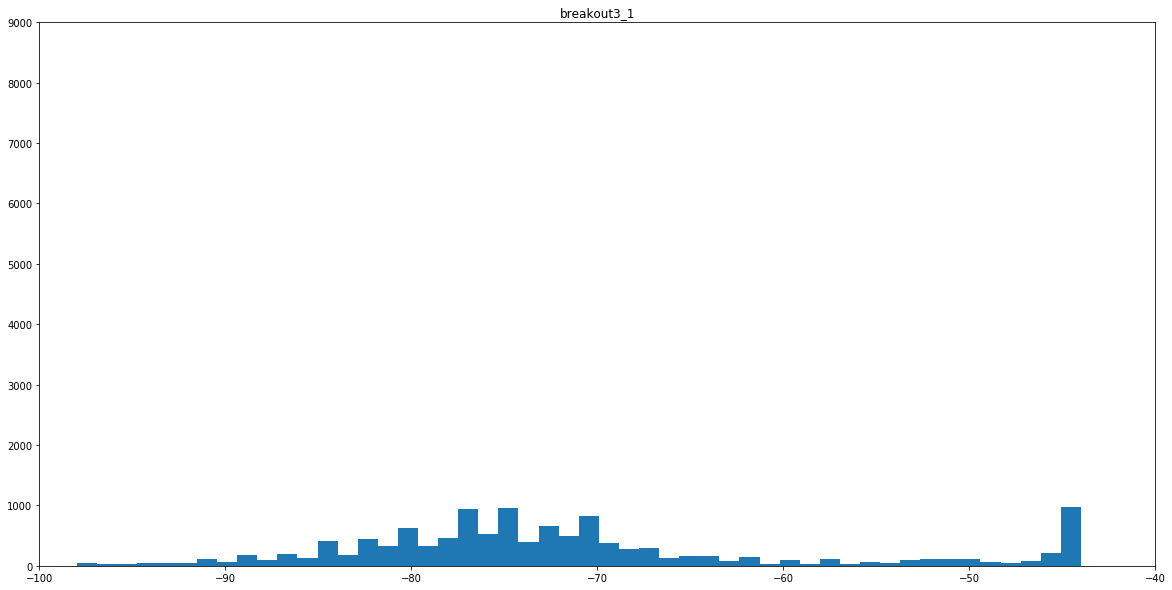

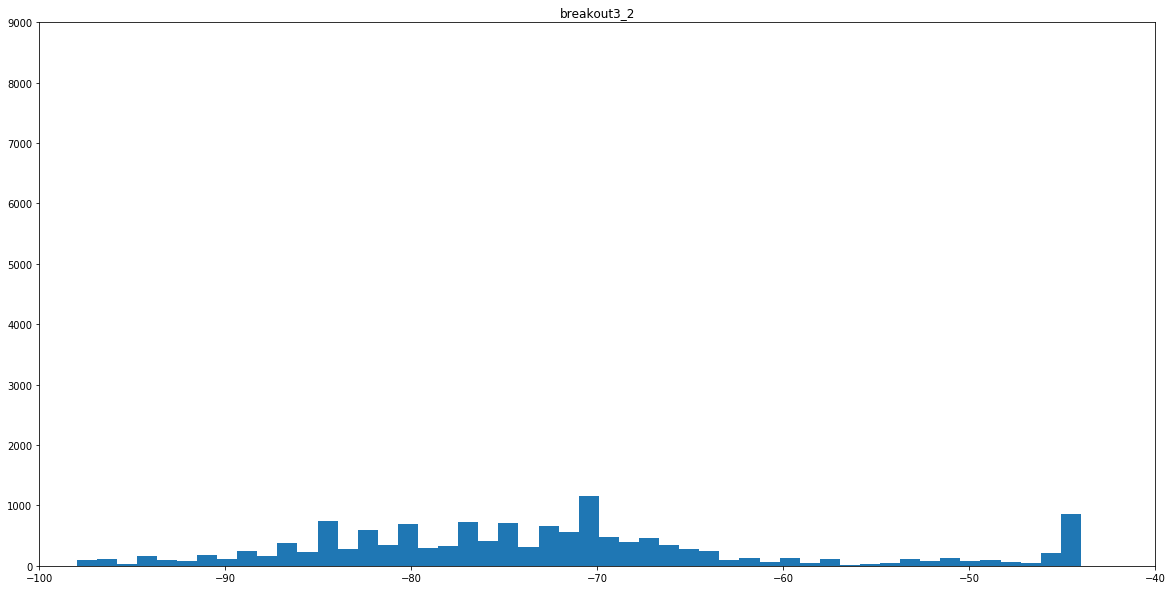

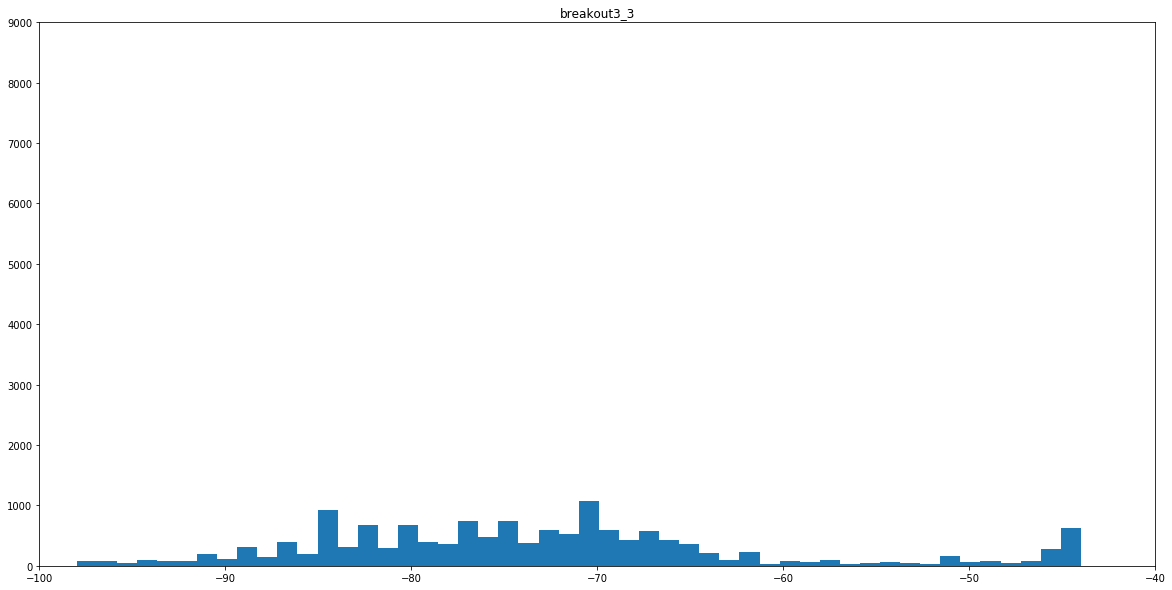

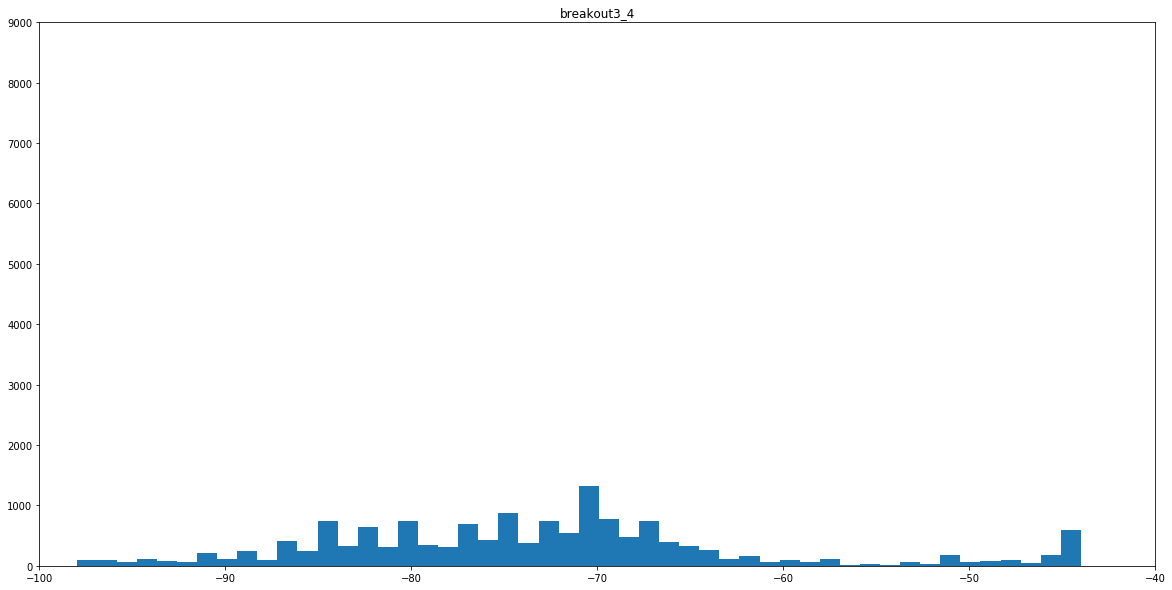

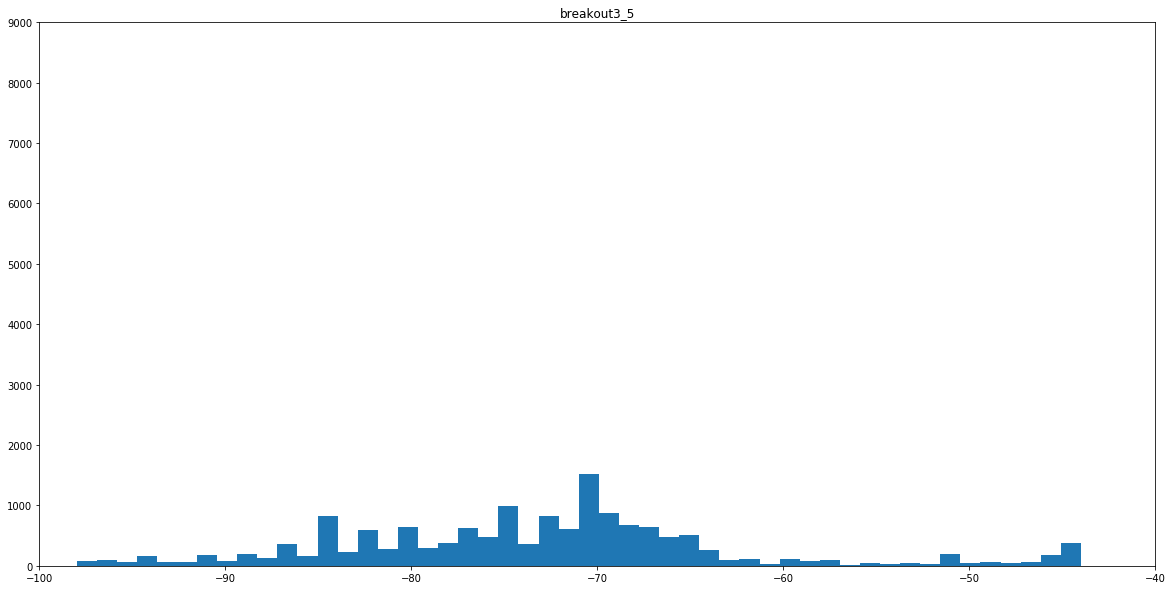

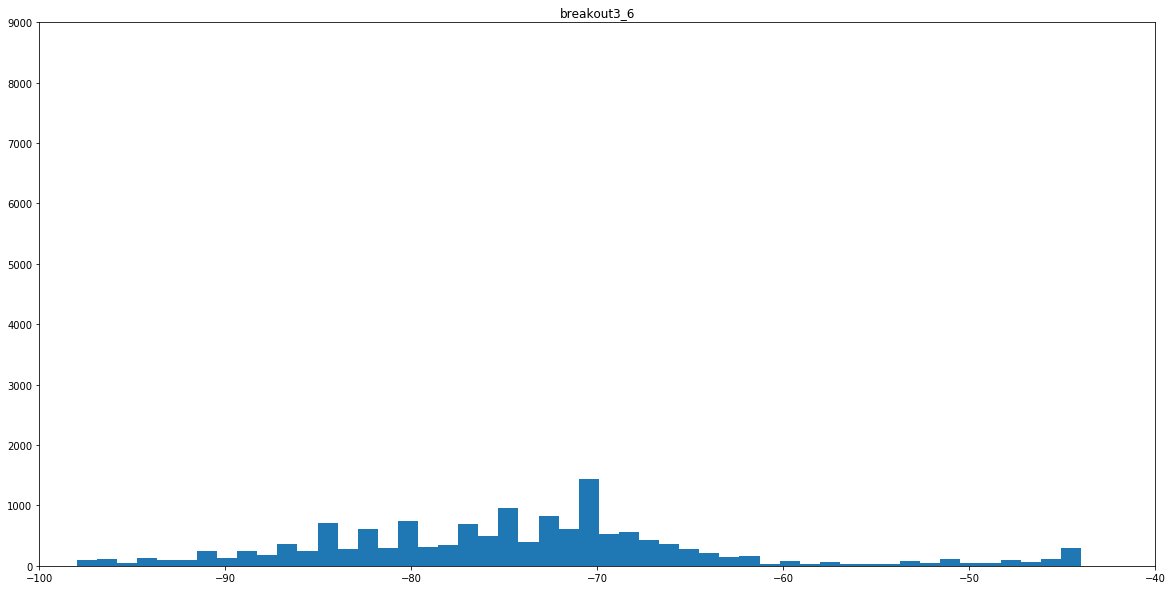

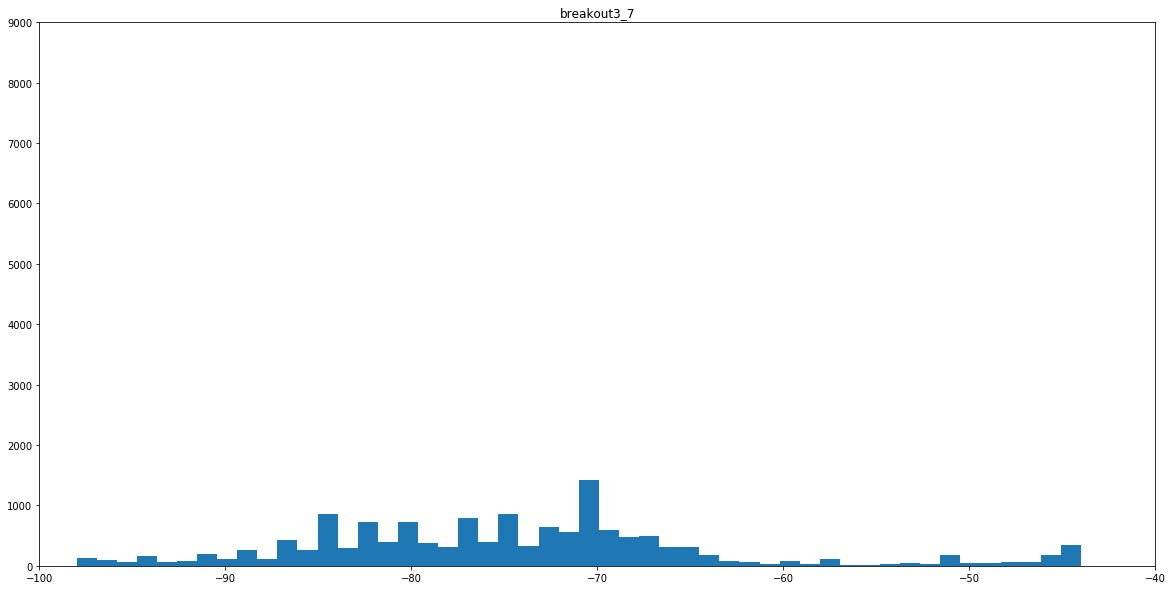

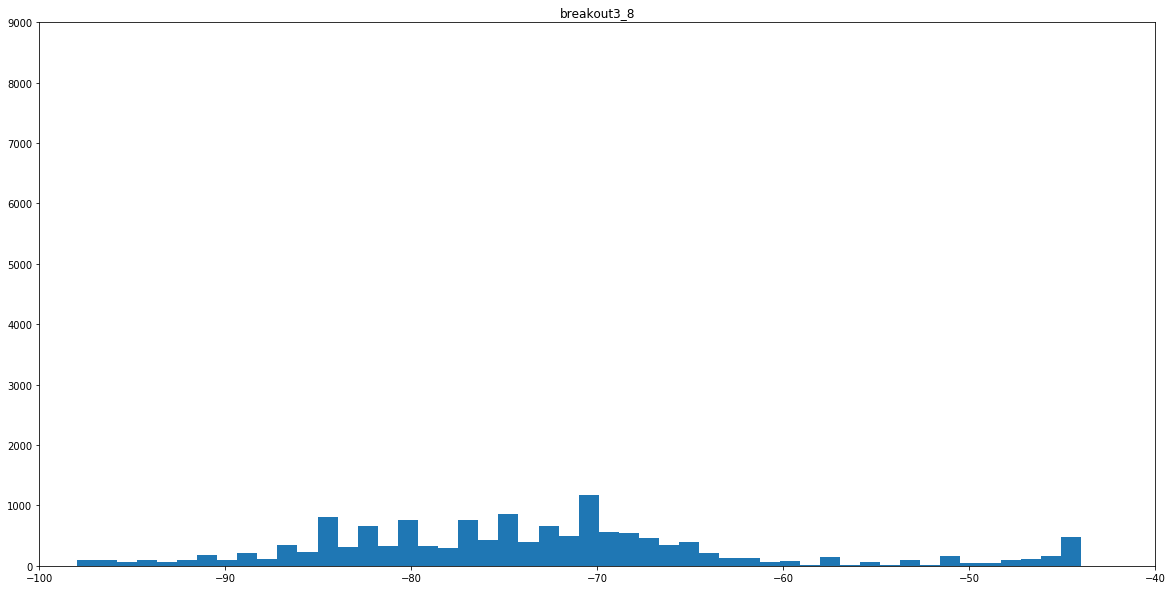

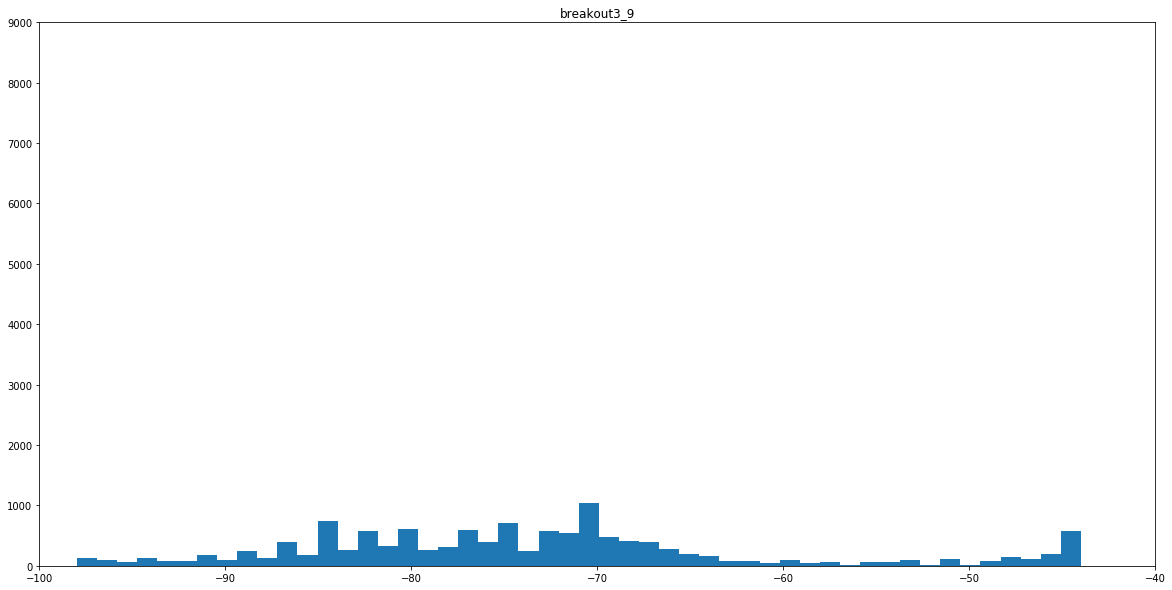

In [68]:
freq_list_3 = []
for i in bo3:
    freq_list_3.append(tmp_m2ms.reset_index().set_index('datetime').loc[i])

hist_list_3 = []
for freq in freq_list_3:
    tmp_freq = []
    for row in freq.iterrows():
        tmp = [row[1][3]]*int(row[1][5])
        tmp_freq = tmp_freq + tmp
    hist_list_3.append(tmp_freq)

pic_dir = "./histograms/breakout3/"
if not os.path.isdir(pic_dir):
    os.makedirs(pic_dir)

for i in range(1, 10):
    plt.figure(figsize=(20,10))
    plt.hist(hist_list_3[i-1], bins=50)
    plt.xlim([-100, -40])
    plt.ylim([0, 9000])
    plt.title('breakout3_{}'.format(i))
    plt.savefig(pic_dir + 'breakout3_{}.png'.format(i))

In [69]:
from natsort import natsorted
from moviepy.editor import *

base_dir = os.path.realpath('./histograms/breakout3')
print(base_dir)

img_list = glob.glob('./histograms/breakout3/*.png')  # Get all the pngs in the current directory
img_list_sorted = natsorted(img_list, reverse=False)  # Sort the images

clips = [ImageClip(m).set_duration(0.8)
         for m in img_list_sorted]

concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip.write_videofile("breakout3.mp4", fps=25)

/Users/songziyu/Desktop/Capstone-URMC/histograms/breakout3


t:   1%|          | 2/180 [00:00<00:13, 13.10it/s, now=None]

Moviepy - Building video breakout3.mp4.
Moviepy - Writing video breakout3.mp4



Moviepy - Done !
Moviepy - video ready breakout3.mp4


**breakout session 4**

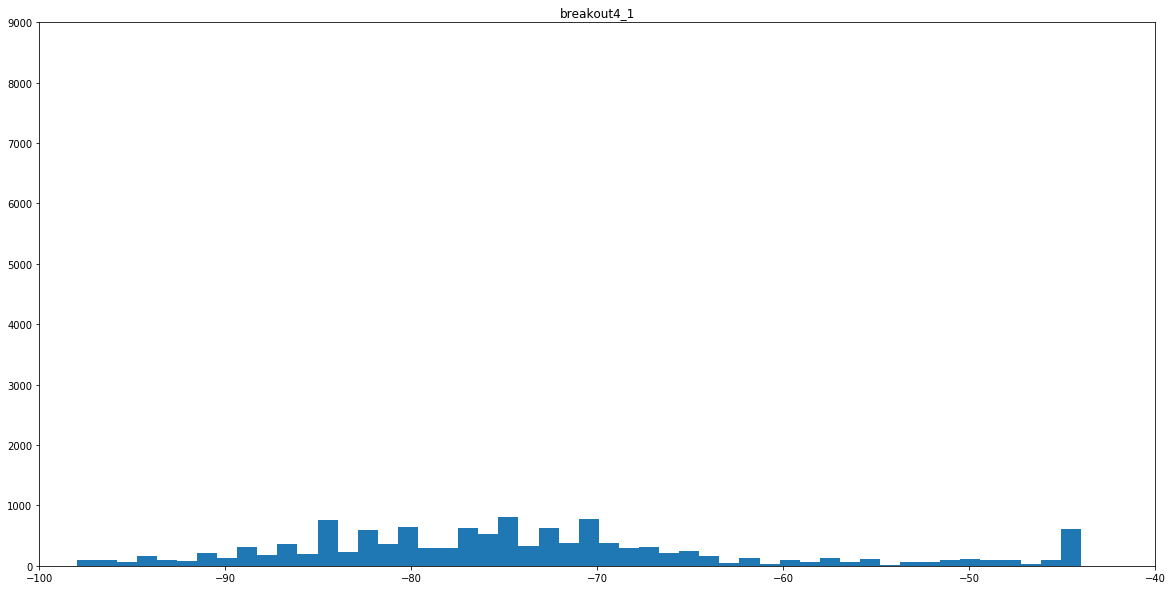

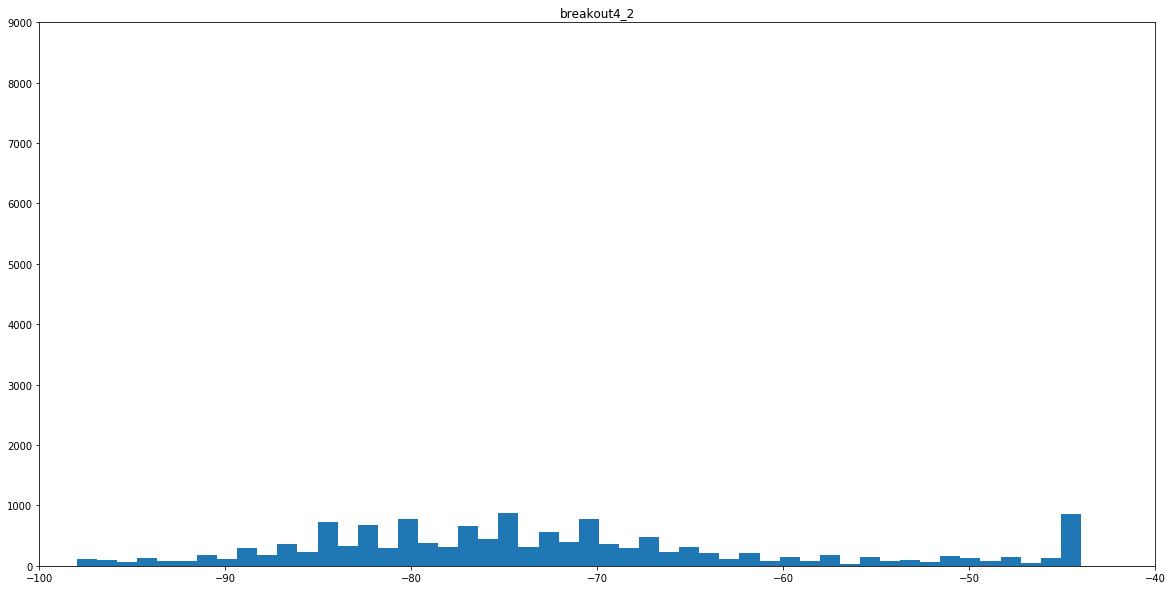

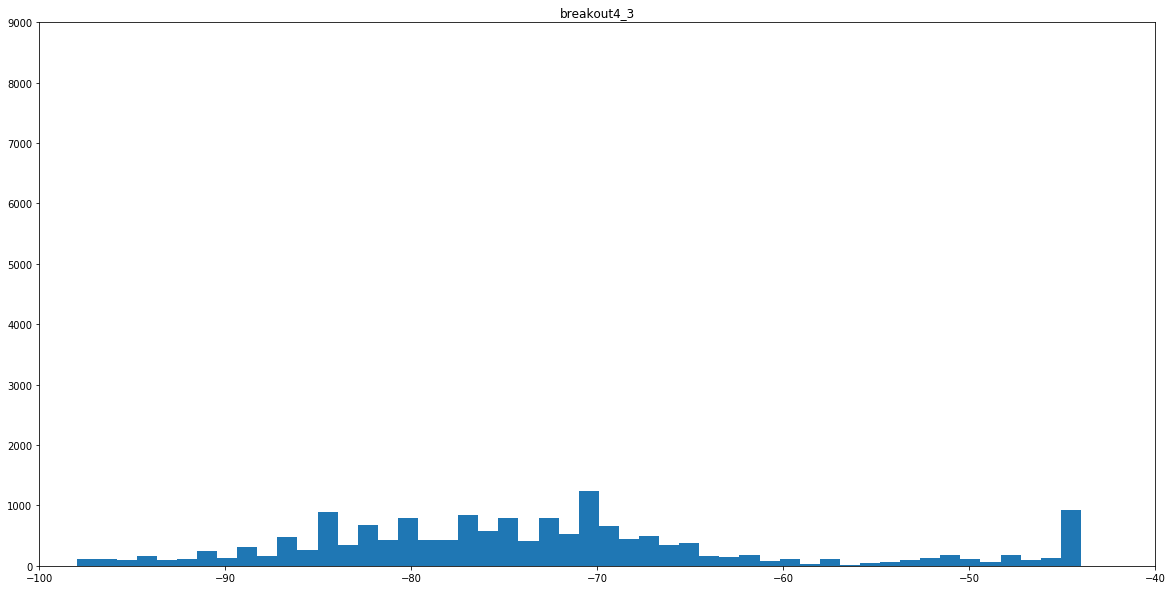

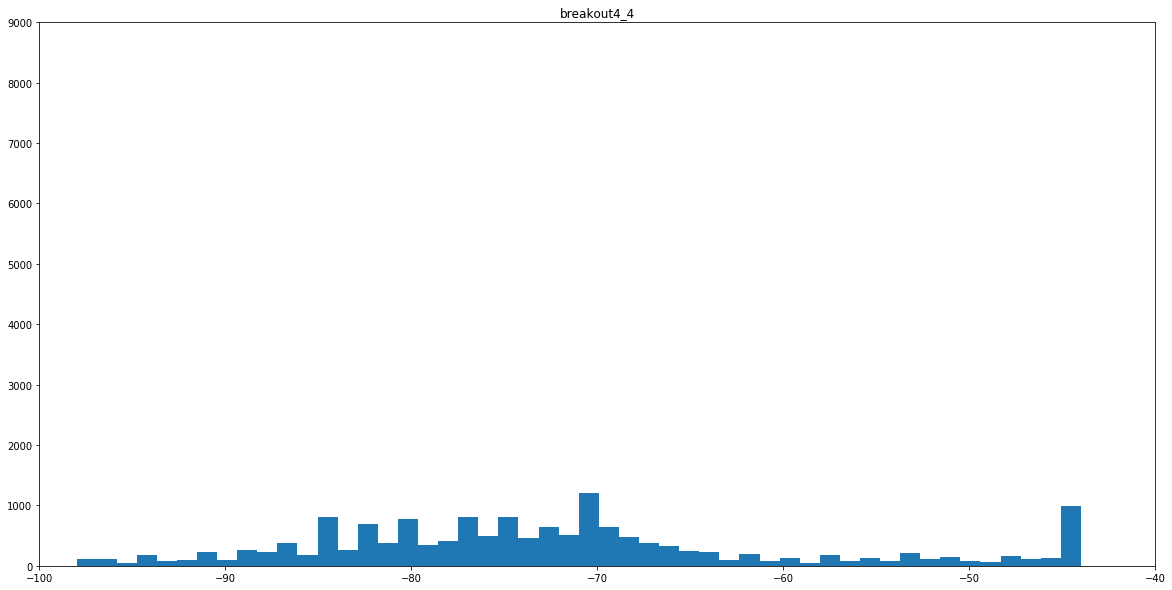

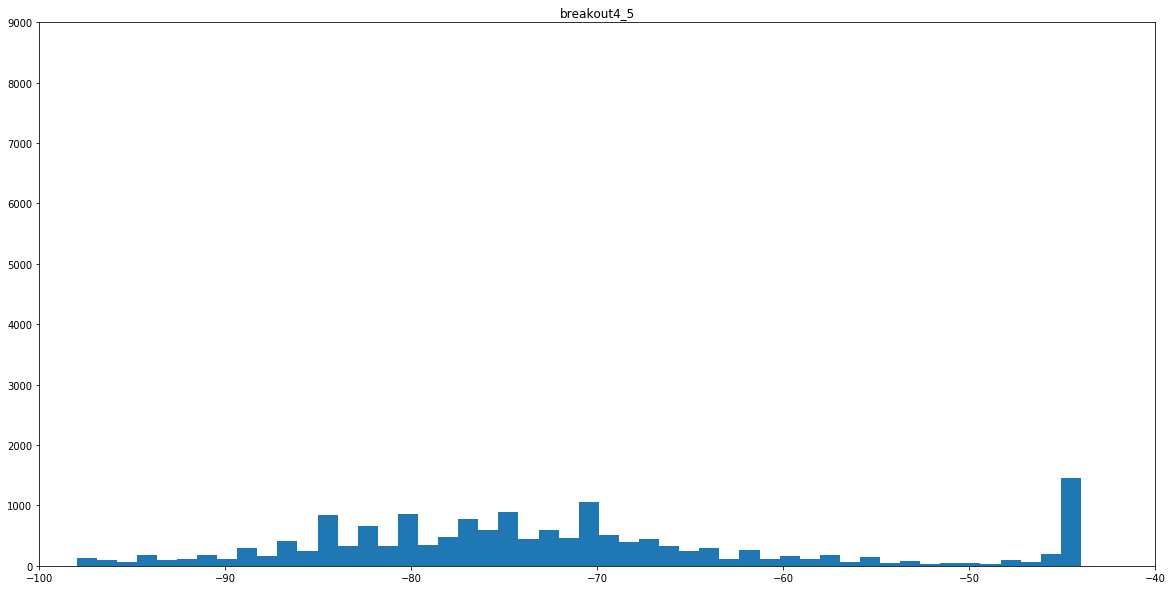

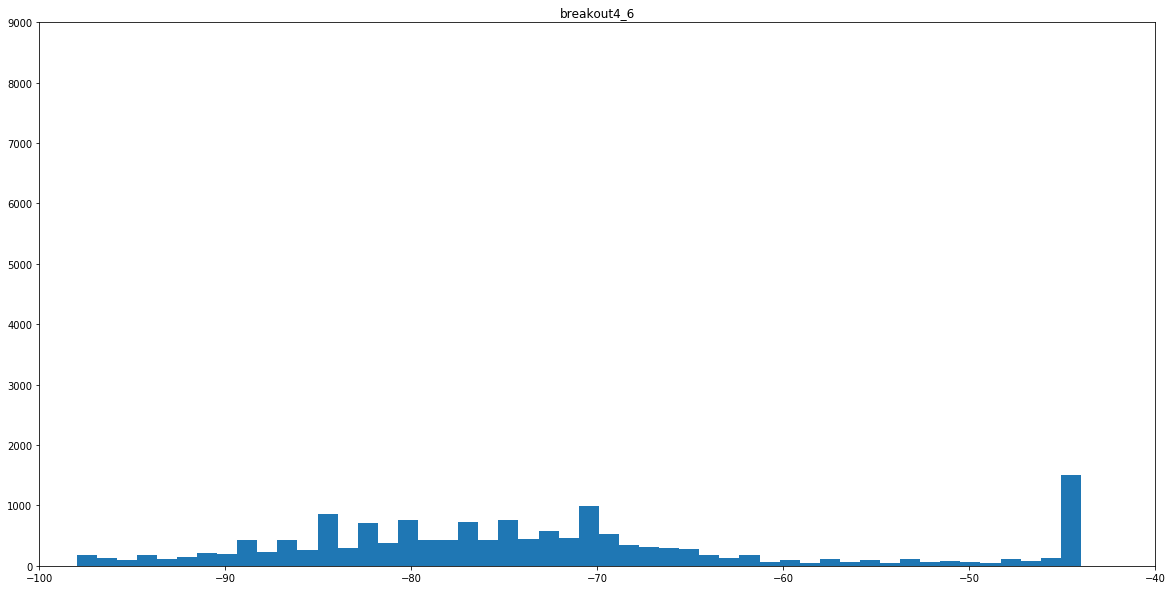

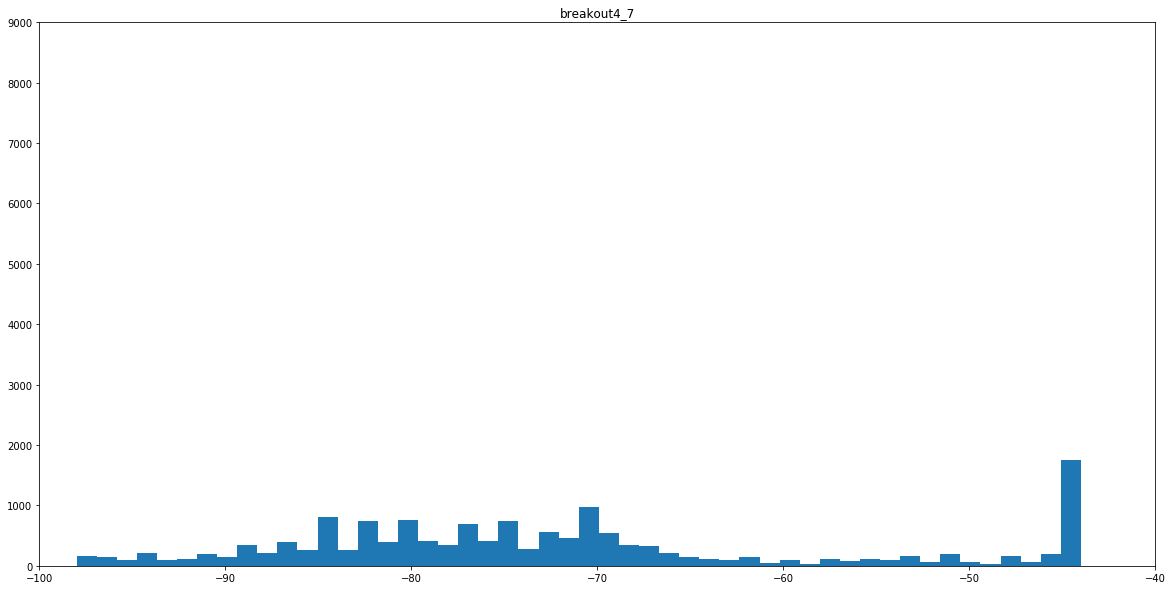

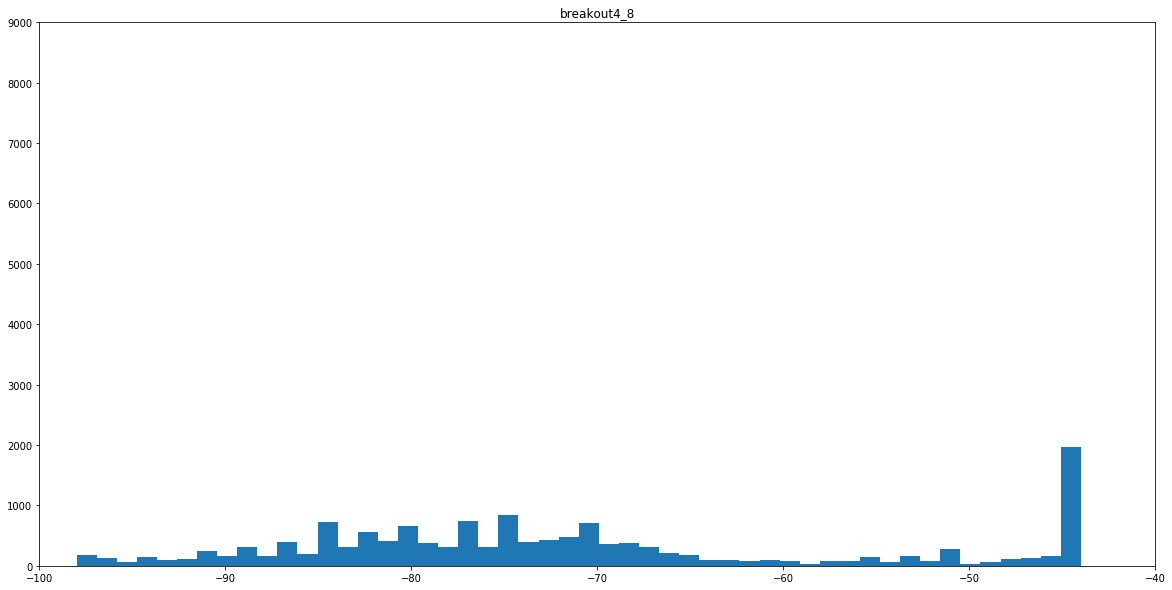

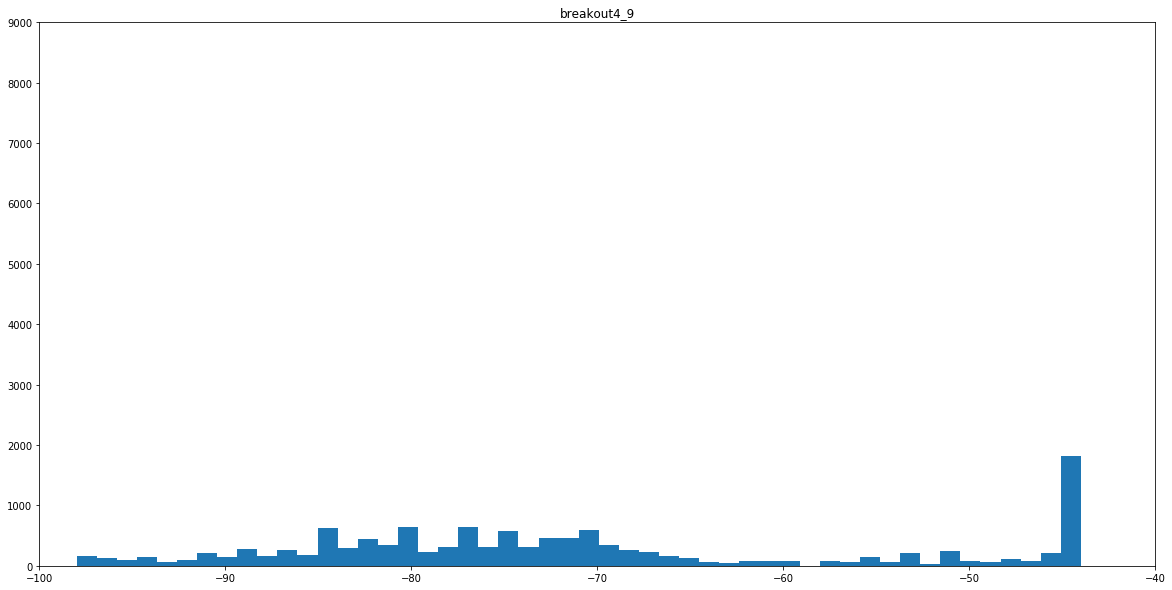

In [70]:
freq_list_4 = []
for i in bo4:
    freq_list_4.append(tmp_m2ms.reset_index().set_index('datetime').loc[i])

hist_list_4 = []
for freq in freq_list_4:
    tmp_freq = []
    for row in freq.iterrows():
        tmp = [row[1][3]]*int(row[1][5])
        tmp_freq = tmp_freq + tmp
    hist_list_4.append(tmp_freq)

pic_dir = "./histograms/breakout4/"
if not os.path.isdir(pic_dir):
    os.makedirs(pic_dir)

for i in range(1, 10):
    plt.figure(figsize=(20,10))
    plt.hist(hist_list_4[i-1], bins=50)
    plt.xlim([-100, -40])
    plt.ylim([0, 9000])
    plt.title('breakout4_{}'.format(i))
    plt.savefig(pic_dir + 'breakout4_{}.png'.format(i))

In [71]:
from natsort import natsorted
from moviepy.editor import *

base_dir = os.path.realpath('./histograms/breakout4')
print(base_dir)

img_list = glob.glob('./histograms/breakout4/*.png')  # Get all the pngs in the current directory
img_list_sorted = natsorted(img_list, reverse=False)  # Sort the images

clips = [ImageClip(m).set_duration(0.8)
         for m in img_list_sorted]

concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip.write_videofile("breakout4.mp4", fps=25)

/Users/songziyu/Desktop/Capstone-URMC/histograms/breakout4


t:   1%|          | 2/180 [00:00<00:12, 13.82it/s, now=None]

Moviepy - Building video breakout4.mp4.
Moviepy - Writing video breakout4.mp4



Moviepy - Done !
Moviepy - video ready breakout4.mp4
